# Make Dataframe of Location Info for CAVA Zip Codes

In [ ]:
#### Import needed libraries

In [2]:
## Standard need libraries
import pandas as pd
import numpy as np

## Libraries to scrape CAVA locations website
import requests
from bs4 import BeautifulSoup as bsoup

## Import library for manipulating json files
import json

## Library to get coordinates from city name
from opencage.geocoder import OpenCageGeocode

## Confirm imports
print('\nLibraries imported\n')


Libraries imported



In [ ]:
#### Adjust dataframe display options

In [3]:
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Confirm adjustments
print('\nOption set to display all dataframe rows and columns\n')


Option set to display all dataframe rows and columns



In [ ]:
#### Scrape html doc with CAVA location info from CAVA website

In [4]:
## Request html
response = requests.get('https://cava.com/locations')

## Check that request worked by printing a few lines
print('\n', response.text[0:250], '\n')

## Make a beautiful soup object with parsed html (for easy info extraction)
cava_soup = bsoup(response.text, 'html.parser')


 <!DOCTYPE html>
<html class="no-js" lang="en">
  <head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="google-site-verification" content="4JONUyauKNrbInlgD43lCmhqWL23ad_-iaED1TjQE3A" />
    <title 



In [ ]:
#### Get all html blocks that have location info for CAVA restaurants

In [5]:
## Use 'find_all' method to get relevant html blocks
cava_locs_soup = cava_soup.find_all('div', class_ = 'adr copy')

## Count CAVA locations
print('\nNumber of CAVA locations: ', len(cava_locs_soup), '\n', sep = '')

## Show structure of html block for first CAVA location info (to know who to extract info)
print(cava_locs_soup[0].prettify())


Number of CAVA locations: 105

<div class="adr copy">
 <div class="street-address">
  8162 East Santa Ana Canyon Rd
 </div>
 <span class="locality">
  Anaheim
 </span>
 ,
 <span class="region">
  CA
 </span>
 <span class="postal-code">
  92808
 </span>
 <div>
  <a href="tel:714-782-7478" title="Call Anaheim Hills">
   714-782-7478
  </a>
 </div>
</div>



In [ ]:
#### Extract info for first listed CAVA location (as example)

In [6]:
## Extract locality (city), region (state), street address, and zip code
locality = cava_locs_soup[0].find('span', class_ = 'locality').text
state = cava_locs_soup[0].find('span', class_ = 'region').text
address = cava_locs_soup[0].find('div', class_ = 'street-address').text
postal_code = cava_locs_soup[0].find('span', class_ = 'postal-code').text

## Show extracted info
print('\nFirst location:\n\n',
      locality, ', ', state, '\n',
      address, ', ', postal_code, '\n',
      sep = '')


First location:

Anaheim, CA
8162 East Santa Ana Canyon Rd, 92808



In [ ]:
#### Get list of needed info for all CAVA locations

In [7]:
## Initialize a list to store all info for conversion to dataframe
cava_info_list = []

## Add info for each CAVA site to above list
for cava in cava_locs_soup:    
    
    city = cava.find('span', class_ = 'locality').text
    state = cava.find('span', class_ = 'region').text
    postal_code = cava.find('span', class_ = 'postal-code').text

    cava_info_list.append([postal_code, ', '.join([city , state])])

## Check that list has info for every CAVA: 105 expected
print('\nExpected number of CAVA locations: 105')
print('Number of CAVA locations in list: ', len(cava_info_list), '\n', sep = '')    

print('Sample locations:')
for city in cava_info_list[0:10]:
    print(city)
print()


Expected number of CAVA locations: 105
Number of CAVA locations in list: 105

Sample locations:
['92808', 'Anaheim, CA']
['92627', 'Costa Mesa, CA']
['90232', 'Culver City, CA']
['92130', 'San Diego, CA']
['92024', 'Encinitas, CA']
['92606', 'Irvine, CA']
['92037', 'La Jolla, CA']
['92108', 'San Diego, CA']
['92691', 'Mission Viejo, CA']
['91101', 'Pasadena, CA']



In [ ]:
#### Convert info list to dataframe

In [8]:
## Convert list to dataframe
cava_loc_info_df = pd.DataFrame(cava_info_list, columns = ['Zip Code', 'City'])

## Fix entry errors (found in course of development)
cava_loc_info_df.loc[47, 'City'] = 'Raleigh, NC'

for i, row in cava_loc_info_df.iterrows():
    if row['City'].split(',')[-1] == ' VA ':
        row['City'] = row['City'].split(',')[0] + ', VA'
        
## Drop duplicate rows (some zip codes have more than 1 CAVA)
cava_loc_info_df.drop_duplicates(inplace = True)

print('\nDataframe Shape: \n', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.head()


Dataframe Shape: 
(101, 2)



,Zip Code,City
0,92808,"Anaheim, CA"
1,92627,"Costa Mesa, CA"
2,90232,"Culver City, CA"
3,92130,"San Diego, CA"
4,92024,"Encinitas, CA"


In [ ]:
#### Add coordinate information and CAVA designation variable (Has CAVA? = 1) to dataframe

In [9]:
## Add variables for coordinates
cava_loc_info_df['Latitude'] = ["NA"] * len(cava_loc_info_df)
cava_loc_info_df['Longitude'] = ["NA"] * len(cava_loc_info_df)

## Get coordinates for each zip code
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

## Initialize variables to keep track of progress through iterations
total = len(cava_loc_info_df)
completed = 0

## For every zip code in the dataframe, get coordiantes of the zip code
for i, row in cava_loc_info_df.iterrows():
    
    # create input for query in format "zip code, state abbreviation" (e.g., 92808, CA)
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])
    
    # query geocoder with the input created above
    location = zip_geocoder.geocode(query = input_address)
    row['Latitude'] = location[0]['geometry']['lat']
    row['Longitude'] = location[0]['geometry']['lng']
    
    # report progress through iterations
    completed += 1
    print('Percent completed: {:%}'.format(completed/total), end = '\r')

## Add variable to record whether zip codes has CAVA (all do for this dataframe)
columns = cava_loc_info_df.columns.tolist()
cava_loc_info_df['Has CAVA?'] = [1] * len(cava_loc_info_df)
cava_loc_info_df = cava_loc_info_df[['Has CAVA?'] + columns]

## Visualize dataframe
print('\n\nDataframe Shape: \n', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.head()

Percent completed: 100.000000%

Dataframe Shape: 
(101, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.8661,-117.743
1,1,92627,"Costa Mesa, CA",33.6379,-117.922
2,1,90232,"Culver City, CA",34.02,-118.399
3,1,92130,"San Diego, CA",32.9627,-117.19
4,1,92024,"Encinitas, CA",33.0444,-117.28


In [ ]:
#### Save dataframe for later use

In [93]:
## Save dataframe
cava_loc_info_df.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_loc_info_df.csv')

## Confirm save
print('\nDataframe saved.')


Dataframe saved.


#### 

# Make Dataframe of Location Info for Non-CAVA Zip Codes in CAVA States

In [ ]:
#### Load CAVA zip codes location dataframe

In [10]:
## Read in dataframe
cava_loc_info_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_loc_info_df.csv', dtype = {'Zip Code' : str}).drop('Unnamed: 0', axis = 1)

## Visualize dataframe
print('\nDataframe shape: ', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.head()


Dataframe shape: (101, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.866069,-117.743210
1,1,92627,"Costa Mesa, CA",33.637937,-117.921739
2,1,90232,"Culver City, CA",34.019962,-118.399337
3,1,92130,"San Diego, CA",32.962655,-117.189656
4,1,92024,"Encinitas, CA",33.044445,-117.280409


In [ ]:
#### Get list of states with CAVA

In [11]:
## Get list of cities (including state abbreviations) that have CAVA
cava_cities = set(cava_loc_info_df['City'])
cava_states = []

## For each city, add state abbreviation to list (will remove duplicates with later set function)
for city in cava_cities:
    cava_states.append(city.split(', ')[-1])

## Eliminate duplicates and ignore DC because we won't be putting any new CAVAs in DC (because it already has so many)
cava_states = list(set(cava_states) - set(['DC']))
cava_states.sort()
print('\nStates with CAVA: {}'.format(cava_states), '\n')


States with CAVA: ['CA', 'CO', 'CT', 'MA', 'MD', 'NC', 'NJ', 'NY', 'PA', 'TN', 'TX', 'VA'] 



In [ ]:
#### Get list of zip codes with CAVA

In [13]:
## Get list of cities with CAVA locations
cava_zips = set(cava_loc_info_df['Zip Code'])

## Show sample zip codes to confirm code worked
print('\nSome zip codes with CAVA:\n\n{}'.format(list(cava_zips)[0:10]), '\n', sep = '')


Some zip codes with CAVA:

['80129', '92627', '20016', '20147', '91367', '22305', '02116', '21045', '22182', '10005']



In [ ]:
#### Make dataframe of zip codes without CAVA (in states with CAVA)

In [14]:
## Initialize the overall dataframe
nocava_loc_info_df = pd.DataFrame(columns=['Zip Code', 'City'])

## Create state abbreviation dictionary
states_abbvs_dict = {
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'NC': 'North Carolina',
        'NJ': 'New Jersey',
        'NY': 'New York',
        'PA': 'Pennsylvania',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'VA': 'Virginia'
}

## Define variables to report progress through code
completed = 0
total = len(cava_states)

## For each state, make dataframe of largest non-CAVA zip codes by population
for state in cava_states:
    
    ## Get zip codes in state with biggest populations
    # write state name in format appropriate for url (use dict to get full state name, remove any spaces, then make lowercase)
    state_name_v1 = ''.join(states_abbvs_dict[state].split(' ')).lower() #use states dict to get full state name, remove any spaces, then make lowercase (for use to find url)
    # read in table from the url
    zips = pd.read_html('https://www.{}-demographics.com/zip_codes_by_population'.format(state_name_v1))[0]['Zip Code'][0:30].astype(str).tolist()          
    # remove zip codes that already have CAVA
    nocava_zips = list(set(zips) - set(cava_zips))      
    # make into dataframe
    nocava_zips_df = pd.DataFrame(nocava_zips, columns=['Zip Code']).reset_index().drop('index', axis =1)
    nocava_zips_df['Zip Code'] = nocava_zips_df['Zip Code'].astype(str)

    ## Get cities associated with zip codes in current state
    # write state name in format appropriate for url
    state_name_v2 = '%20'.join(states_abbvs_dict[state].split(' '))
    # read in table from the url
    cits_df = pd.read_html('https://www.zipcodestogo.com/{}/'.format(state_name_v2))[1].iloc[2:,0:2].reset_index().drop('index', axis = 1)
    # relabel columns for easier referencing
    cits_df.columns = ['Zip Code', 'City']
    # make zip codes type: str
    cits_df['Zip Code'] = cits_df['Zip Code'].astype(str)
    # add state abbreviation to city names
    cits_df['City'] = cits_df['City'] + ', ' + state
    
    ## Merge 'no_cava_postals_df' and 'cits_df'
    nocava_zips_df = nocava_zips_df.merge(cits_df, on = 'Zip Code')
    
    ## Add state-specific dataframe to overall dataframe with append method
    nocava_loc_info_df = nocava_loc_info_df.append(nocava_zips_df)
    
    ## Report progres through iterations
    completed += 1
    print('Percent completed: {:%}'.format(completed/total), end = '\r')


## Visualize the created dataframe
print('\n\nDataframe shape: ', nocava_loc_info_df.shape, '\n', sep = '')
nocava_loc_info_df.head()

Percent completed: 100.000000%

Dataframe shape: (345, 2)



,Zip Code,City
0,92335,"Fontana, CA"
1,91911,"Chula Vista, CA"
2,90201,"Bell, CA"
3,92376,"Rialto, CA"
4,92126,"San Diego, CA"


In [ ]:
#### Add coordinates and CAVA designation ('Has CAVA?' = 0) to dataframe

In [15]:
## Reset 'nocava_loc_df' index and drop old indexing from sub dataframes
nocava_loc_info_df = nocava_loc_info_df.reset_index().drop('index', axis = 1)
nocava_loc_info_df['Latitude'] = ['NA'] * len(nocava_loc_info_df)
nocava_loc_info_df['Longitude'] = ['NA'] * len(nocava_loc_info_df)
nocava_loc_info_df['Has CAVA?'] = 0 * len(nocava_loc_info_df)

## Assign 'Has CAVA' variable to '0'
nocava_loc_info_df['Has CAVA?'] = [0] * len(nocava_loc_info_df)

## Define credentials for geocoding API
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

## Initialize variables to keep track of progress through iterations
total_items = len(nocava_loc_info_df)
completed_items = 0

## For every zip code, get coordinates
for i, row in nocava_loc_info_df.iterrows():
    
    # format query as follows: "zip code, state" (e.g., "92335, CA")
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])

    # make query
    location = zip_geocoder.geocode(query = input_address)
    nocava_loc_info_df.loc[i, 'Latitude'] = location[0]['geometry']['lat']
    nocava_loc_info_df.loc[i, 'Longitude'] = location[0]['geometry']['lng']
    
    # report progress through iterations
    completed_items += 1
    print('Percent remaining: {:%}'.format(completed_items/total_items), end = '\r')

## Rearrange columns for consistency
nocava_loc_info_df = nocava_loc_info_df[['Has CAVA?','Zip Code','City','Latitude','Longitude']]    
   
## Visualize the dataframe
print('\nDataframe shape: ', nocava_loc_info_df.shape, '\n')
nocava_loc_info_df.head()

Percent remaining: 100.000000%
Dataframe shape:  (345, 5) 



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,0,92335,"Fontana, CA",34.0976,-117.566
1,0,91911,"Chula Vista, CA",32.6099,-117.053
2,0,90201,"Bell, CA",33.9664,-118.153
3,0,92376,"Rialto, CA",34.1094,-117.374
4,0,92126,"San Diego, CA",32.9169,-117.145


In [ ]:
#### Save dataframe

In [95]:
## Save dataframe
nocava_loc_info_df.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/nocava_loc_info_df.csv')

## Report save
print('\nDataframe saved.')


Dataframe saved.


#### 

# Combine Location Info Dataframes for CAVA and non-CAVA Zip Codes

In [ ]:
#### Load location info dataframe for CAVA zip codes

In [12]:
## Load dataframe
cava_loc_info_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_loc_info_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', cava_loc_info_df.shape, '\n', sep = '')
cava_loc_info_df.head()


Dataframe shape: (101, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.866069,-117.743210
1,1,92627,"Costa Mesa, CA",33.637937,-117.921739
2,1,90232,"Culver City, CA",34.019962,-118.399337
3,1,92130,"San Diego, CA",32.962655,-117.189656
4,1,92024,"Encinitas, CA",33.044445,-117.280409


In [14]:
#### Load location info dataframe for non-CAVA zip codes

In [13]:
## Load dataframe
nocava_loc_info_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/nocava_loc_info_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', nocava_loc_info_df.shape, '\n', sep = '')
nocava_loc_info_df.head()


Dataframe shape: (345, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,0,92335,"Fontana, CA",34.097638,-117.565735
1,0,91911,"Chula Vista, CA",32.609922,-117.052666
2,0,90201,"Bell, CA",33.966408,-118.153371
3,0,92376,"Rialto, CA",34.109370,-117.373974
4,0,92126,"San Diego, CA",32.916884,-117.144745


In [ ]:
#### Combine above dataframes

In [14]:
## Use append method to combine dataframes
combined_loc_info_df = cava_loc_info_df.append(nocava_loc_info_df).reset_index().drop(['index'], axis = 1)
combined_loc_info_df.drop_duplicates(inplace = True)

## Find expected dataframe size
print('\nExpected dataframe shape: ({}, {})'.format(len(cava_loc_info_df) + len(nocava_loc_info_df), len(cava_loc_info_df.columns)))

## Show dataframe
print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.head()


Expected dataframe shape: (446, 5)

Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.866069,-117.743210
1,1,92627,"Costa Mesa, CA",33.637937,-117.921739
2,1,90232,"Culver City, CA",34.019962,-118.399337
3,1,92130,"San Diego, CA",32.962655,-117.189656
4,1,92024,"Encinitas, CA",33.044445,-117.280409


In [ ]:
#### Save created dataframe

In [97]:
## Save dataframe
combined_loc_info_df.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_combo_loc_info_df.csv')

## Report save
print('\nDataframe saved.')


Dataframe saved.


#### 

# Get Dataframe of Venues Around Each Zip Code in Combined Location Info Dataframe

In [ ]:
#### Load combined location info dataframe

In [15]:
## Read in dataframe
combined_loc_info_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_combo_loc_info_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.head()


Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.866069,-117.743210
1,1,92627,"Costa Mesa, CA",33.637937,-117.921739
2,1,90232,"Culver City, CA",34.019962,-118.399337
3,1,92130,"San Diego, CA",32.962655,-117.189656
4,1,92024,"Encinitas, CA",33.044445,-117.280409


In [ ]:
#### Define credentials and version for Foursquare API

In [22]:
## Define credentials
CLIENT_ID = 'C5TVLNNOZ3QX14URLNVGVXAKYHOT421V0KR21MSGVJY1O2CR' # my Foursquare ID
CLIENT_SECRET = 'BCTZ4WTEUPUZWKQO0RBRZQZUJ3QDSXV1Y2BKIW5VGUP32M2H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Report
print('\nCredentials defined.\n')


Credentials defined.



In [ ]:
#### Define function to get venues for each postal code in a dataframe using Foursquare API 'explore' endpoint

In [23]:
### ### ###
def getNearbyVenuesExplore(desigs, cities, postals, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    
    total = len(desigs)
    completed = 0
    
    for desig, city, postal, lat, lng in zip(desigs, cities, postals, latitudes, longitudes):

        ## Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
        
        try: # to account for empty 'response' returns
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            results = []
        
        ## Return only relevant information for each nearby venue
        for v in results:
            try: # to account for venue returns with empty 'category'
                venues_list.append([desig,
                                        city,
                                        postal,
                                        lat,
                                        lng,
                                        v['venue']['name'],
                                        v['venue']['categories'][0]['name']])
            except KeyError:
                pass

        ## Show progress as percentage of 'result' output processed
        completed += 1
        print('Percent completed: {:%}'.format(completed/total), end = '\r')
        

    ## Make 'venues_list' into a dataframe        
    nearby_vens = pd.DataFrame(venues_list)
    nearby_vens.columns = ['Has CAVA?',
                           'City',
                           'Zip Code',
                           'Latitude',
                           'Longitude',
                           'Venue',
                           'Venue Category']
    
    return(nearby_vens)

### ### ###

In [ ]:
#### Use function 'getNearbyVenuesExplore' to get venues for each postal code in combined location info dataframe

In [24]:
## Run function for dataframe
near_vens_df = getNearbyVenuesExplore(combined_loc_info_df['Has CAVA?'],
                                      combined_loc_info_df['City'],
                                      combined_loc_info_df['Zip Code'],
                                      combined_loc_info_df['Latitude'],
                                      combined_loc_info_df['Longitude'],
                                      3200,
                                      100
                                     )
## Drop any duplicate rows
near_vens_df.drop_duplicates(inplace = True)


## Show dataframe
print('\r                                                          ')
print('Percent completed: 100%')
print('\nDataframe shape: ', near_vens_df.shape, '\n', sep = '')   
near_vens_df.head()

                                                          
Processing complete.

Dataframe shape: (32052, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
0,1,"Anaheim, CA",92808,33.866069,-117.74321,Bodhi Leaf Coffee Traders,Coffee Shop
1,1,"Anaheim, CA",92808,33.866069,-117.74321,Chipotle Mexican Grill,Mexican Restaurant
2,1,"Anaheim, CA",92808,33.866069,-117.74321,Rosine's Mediterranean Grill,Mediterranean Restaurant
3,1,"Anaheim, CA",92808,33.866069,-117.74321,Wood Ranch BBQ & Grill,BBQ Joint
4,1,"Anaheim, CA",92808,33.866069,-117.74321,Sprouts Farmers Market,Grocery Store


In [ ]:
#### Eliminate rows corresponding to a CAVA

In [25]:
## Record dataframe shape before dropping CAVA venues
pre_drop_shape = near_vens_df.shape

## Make all entries for 'Venue' lowercase to homogenize for elimination of anything containing 'cava'
near_vens_df['Venue'] = near_vens_df['Venue'].str.lower()

## Eliminate any row where 'Venue' contains "cava"
for i, row in near_vens_df.iterrows():
    if row['Venue'] in ['cava', 'cava grill', 'cava mezze']:
        near_vens_df.drop(i, inplace = True)

## Record dataframe shape after dropping CAVA venues
post_drop_shape = near_vens_df.shape

## Check all instances of "cava" are eliminated
# Show dataframe shape change
print('\nDataframe shape before dropping returned CAVA locations: {}'.format(pre_drop_shape))
print('Dataframe shape after dropping returned CAVA locations:    {}'.format(post_drop_shape))
print('Number of rows dropped: {}'.format(pre_drop_shape[0] - post_drop_shape[0]), '\n')
# Show that no 'cava' instances occur by sorting and subsetting to all venues starting with 'cav'
near_vens_df[near_vens_df['Venue'].str.startswith('cav')].sort_values(by = 'Venue')


Dataframe shape before dropping returned CAVA locations: (32052, 7)
Dataframe shape after dropping returned CAVA locations: (31989, 7)
Number of rows dropped: 63 



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
23843,0,"Bloomfield, NJ",07003,40.807962,-74.187466,cavallo's market,Italian Restaurant
1199,1,"Woodland Hills, CA",91367,34.179980,-118.599510,cavaretta's italian groceries,Deli / Bodega
19607,0,"Owings Mills, MD",21117,39.456003,-76.739490,caves valley golf club,Golf Course
19611,0,"Owings Mills, MD",21117,39.456003,-76.739490,caves valley historic district,Historic Site


In [ ]:
#### Show number of nearby venues for each zip code  

In [26]:
## Group venues dataframe by zip code
near_vens_grouped_df = near_vens_df.groupby(by = 'Zip Code').count().reset_index()[['Zip Code','City']]
near_vens_grouped_df.columns = ['Zip Code','Number of Venues']

## Find number of zip codes with no returned values
no_ven_zips = set(combined_loc_info_df['Zip Code']) - set(near_vens_grouped_df['Zip Code'])

print('\nNumber of postal codes searched for venues: {}'.format(len(combined_loc_info_df)))
print('Number of postal codes with no returned venues: {}'.format(len(no_ven_zips)), sep = '') 

## Show zip codes with no returns
print('\nZip codes with no returned venues:\n')
if len(no_ven_zips) == 0:
    print("None\n")
else:
    for post in no_ven_zips:
        print(post)

## Confirm dataframe is as expected
print('\nExpected # rows in new dataframe: {}'.format(len(combined_loc_info_df) - len(no_ven_zips)), sep = '') # add four because 'combined_loc_info_df' contains ['Has CAVA?', 'City', 'Latitude','Longitude']
print('Dataframe shape: ', near_vens_grouped_df.shape, '\n', sep = '')
near_vens_grouped_df.head()


Number of postal codes searched for venues: 446
Number of postal codes with no returned venues: 1

Zip codes with no returned venues:

07104

Expected # rows in new dataframe: 445
Dataframe shape: (445, 2)



,Zip Code,Number of Venues
0,01040,60
1,01085,58
2,01201,73
3,01420,57
4,01453,65


In [ ]:
#### Save created venue dataset

In [99]:
## Save dataframe
near_vens_df.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_uncoded_venue_df.csv')

## Report
print('\nDataset saved.\n')


Dataset saved.



#### 

# Code Venue Types in Venue Dataframe

In [ ]:
#### Load venue dataframe

In [16]:
## Load dataframe
near_vens_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_uncoded_venue_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', near_vens_df.shape, '\n', sep = '')
near_vens_df.head()


Dataframe shape: (31989, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
0,1,"Anaheim, CA",92808,33.866069,-117.74321,bodhi leaf coffee traders,Coffee Shop
1,1,"Anaheim, CA",92808,33.866069,-117.74321,chipotle mexican grill,Mexican Restaurant
2,1,"Anaheim, CA",92808,33.866069,-117.74321,rosine's mediterranean grill,Mediterranean Restaurant
3,1,"Anaheim, CA",92808,33.866069,-117.74321,wood ranch bbq & grill,BBQ Joint
4,1,"Anaheim, CA",92808,33.866069,-117.74321,sprouts farmers market,Grocery Store


In [29]:
#### Load combined location info dataframe

In [17]:
## Load dataframe
combined_loc_info_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_combo_loc_info_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

# Show dataframe
print('\nDataframe shape: ', combined_loc_info_df.shape, '\n', sep = '')
combined_loc_info_df.head()


Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
0,1,92808,"Anaheim, CA",33.866069,-117.743210
1,1,92627,"Costa Mesa, CA",33.637937,-117.921739
2,1,90232,"Culver City, CA",34.019962,-118.399337
3,1,92130,"San Diego, CA",32.962655,-117.189656
4,1,92024,"Encinitas, CA",33.044445,-117.280409


In [ ]:
#### Recode dataframe by venue type

In [68]:
## Recode each row to show venue type
# Use .get_dummies() method for recoding
near_vens_onehot_df = pd.get_dummies(near_vens_df[['Venue Category']], prefix = "", prefix_sep="")

## Add zip code variable back to recoded dataframe
near_vens_onehot_df['Zip Code'] = near_vens_df['Zip Code']

## Reorder columns for consistency and easy interpretation
ord_cols = list(set(near_vens_onehot_df.columns.tolist()) - set(['Zip Code', 'Has CAVA?']))
near_vens_onehot_df = near_vens_onehot_df[['Zip Code'] + ord_cols]

## Show created dataframe
print('\nDataframe shape: ', near_vens_onehot_df.shape, '\n', sep = '')
near_vens_onehot_df.head()


Dataframe shape: (31989, 502)



,Zip Code,School,Capitol Building,Student Center,Dry Cleaner,Forest,Food Court,Pool Hall,Music School,Colombian Restaurant,Bakery,Australian Restaurant,Building,Record Shop,Farm,Market,Museum,Bus Line,Fast Food Restaurant,Indian Restaurant,National Park,Halal Restaurant,Outdoors & Recreation,Empanada Restaurant,Toy / Game Store,Home Service,Art Museum,Soccer Stadium,Women's Store,Concert Hall,Resort,Hookah Bar,Bath House,Multiplex,Board Shop,Fish & Chips Shop,Rest Area,Garden Center,Greek Restaurant,Train Station,Dive Bar,General Entertainment,Peruvian Restaurant,Mongolian Restaurant,Jazz Club,New American Restaurant,Beach,Pool,Beer Garden,Seafood Restaurant,Korean Restaurant,Mac & Cheese Joint,Baby Store,Assisted Living,Indonesian Restaurant,French Restaurant,English Restaurant,Travel Agency,Bubble Tea Shop,Pedestrian Plaza,Poke Place,Paella Restaurant,Spanish Restaurant,American Restaurant,Amphitheater,Laser Tag,Shipping Store,Laundromat,Golf Course,Zoo,Train,Organic Grocery,Shopping Mall,Garden,Light Rail Station,Arts & Entertainment,Taco Place,Theme Park,Beer Bar,Falafel Restaurant,Food & Drink Shop,Stables,Warehouse Store,Costume Shop,Gymnastics Gym,Art Gallery,Vegetarian / Vegan Restaurant,Aquarium,Shoe Store,Arepa Restaurant,Exhibit,German Restaurant,Sculpture Garden,Cafeteria,College Quad,Motorsports Shop,Dog Run,Advertising Agency,Furniture / Home Store,Country Dance Club,Brazilian Restaurant,Bridge,Waste Facility,Mattress Store,Lawyer,Hawaiian Restaurant,Sri Lankan Restaurant,Bed & Breakfast,Monument / Landmark,Department Store,High School,Roof Deck,Smoothie Shop,Lighthouse,Tennis Court,Deli / Bodega,Optical Shop,Farmers Market,State / Provincial Park,Outlet Store,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Polish Restaurant,Water Park,Pet Café,Radio Station,Health Food Store,Chinese Restaurant,Car Wash,Bike Trail,Pharmacy,Animal Shelter,Flower Shop,Nail Salon,Tattoo Parlor,College Academic Building,Other Repair Shop,Bay,Beach Bar,Eastern European Restaurant,Watch Shop,Scenic Lookout,Italian Restaurant,Hardware Store,Middle Eastern Restaurant,Clothing Store,Truck Stop,College Classroom,Business Service,Hotel,Gym / Fitness Center,Nature Preserve,Event Space,Baseball Field,Ski Lodge,Lingerie Store,Community Center,Shop & Service,Toll Booth,Liquor Store,Street Art,Insurance Office,Afghan Restaurant,Airport,Design Studio,African Restaurant,Photography Studio,Speakeasy,Pilates Studio,Neighborhood,Churrascaria,Boat or Ferry,Circus,Auto Workshop,Martial Arts School,Ski Area,Paintball Field,Check Cashing Service,Heliport,Sporting Goods Shop,Dessert Shop,Recycling Facility,Venezuelan Restaurant,Rental Service,Lighting Store,Hobby Shop,Pastry Shop,Irish Pub,College Rec Center,Bank,ATM,Music Venue,Breakfast Spot,Platform,Taiwanese Restaurant,Big Box Store,Burrito Place,Fair,Hotpot Restaurant,Ethiopian Restaurant,Buffet,Post Office,Chiropractor,Rock Climbing Spot,Office,Shabu-Shabu Restaurant,Weight Loss Center,Parking,Rental Car Location,Comfort Food Restaurant,Music Store,Courthouse,Supermarket,Performing Arts Venue,Gaming Cafe,Snack Place,Bar,Roller Rink,Arcade,Cosmetics Shop,Medical Center,Pizza Place,Diner,Recording Studio,Dutch Restaurant,Food Stand,Airport Service,Basketball Stadium,Tea Room,Drive-in Theater,Coffee Shop,Fruit & Vegetable Store,History Museum,Creperie,Skating Rink,Police Station,Soccer Field,Skate Park,Campground,Currency Exchange,Cheese Shop,Men's Store,Planetarium,Food Truck,Playground,Hunan Restaurant,Gas Station,Massage Studio,Indie Theater,RV Park,Residential Building (Apartment / Condo),Eye Doctor,Grocery Store,Karaoke Bar,Hostel,Beer Store,Doctor's Office,Swim School,Drugstore,Mobile Phone Shop,Opera House,Sake Bar,Leather Goods Store,Cantonese Restaurant,River,Jewish Restaurant,Sandwich Place,Spiritual Center,Sushi Restaurant,Jewelry Store,Kitchen Supply Store,Tennis Stadium,Café,Locksmith,College Basketball Court,College Cafeteria,Disc Golf,Scandinavian Restaurant,Persian Restaurant,Internet 

In [32]:
#### Group recoded dataset by zip code

In [69]:
## Drop 'City' variable if returned by Foursquare API (different from 'City' variable I assigned)
try: #sometimes a 'City' variable is returned by the 'explore' endpoint
    near_vens_onehot_grouped_df = near_vens_onehot_df.groupby(by = 'Zip Code').sum().reset_index().drop('City', axis = 1)
except KeyError:
    near_vens_onehot_grouped_df = near_vens_onehot_df.groupby(by = 'Zip Code').sum().reset_index()

## Show dataframe
print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.head()


Dataframe shape: (445, 502)



,Zip Code,School,Capitol Building,Student Center,Dry Cleaner,Forest,Food Court,Pool Hall,Music School,Colombian Restaurant,Bakery,Australian Restaurant,Building,Record Shop,Farm,Market,Museum,Bus Line,Fast Food Restaurant,Indian Restaurant,National Park,Halal Restaurant,Outdoors & Recreation,Empanada Restaurant,Toy / Game Store,Home Service,Art Museum,Soccer Stadium,Women's Store,Concert Hall,Resort,Hookah Bar,Bath House,Multiplex,Board Shop,Fish & Chips Shop,Rest Area,Garden Center,Greek Restaurant,Train Station,Dive Bar,General Entertainment,Peruvian Restaurant,Mongolian Restaurant,Jazz Club,New American Restaurant,Beach,Pool,Beer Garden,Seafood Restaurant,Korean Restaurant,Mac & Cheese Joint,Baby Store,Assisted Living,Indonesian Restaurant,French Restaurant,English Restaurant,Travel Agency,Bubble Tea Shop,Pedestrian Plaza,Poke Place,Paella Restaurant,Spanish Restaurant,American Restaurant,Amphitheater,Laser Tag,Shipping Store,Laundromat,Golf Course,Zoo,Train,Organic Grocery,Shopping Mall,Garden,Light Rail Station,Arts & Entertainment,Taco Place,Theme Park,Beer Bar,Falafel Restaurant,Food & Drink Shop,Stables,Warehouse Store,Costume Shop,Gymnastics Gym,Art Gallery,Vegetarian / Vegan Restaurant,Aquarium,Shoe Store,Arepa Restaurant,Exhibit,German Restaurant,Sculpture Garden,Cafeteria,College Quad,Motorsports Shop,Dog Run,Advertising Agency,Furniture / Home Store,Country Dance Club,Brazilian Restaurant,Bridge,Waste Facility,Mattress Store,Lawyer,Hawaiian Restaurant,Sri Lankan Restaurant,Bed & Breakfast,Monument / Landmark,Department Store,High School,Roof Deck,Smoothie Shop,Lighthouse,Tennis Court,Deli / Bodega,Optical Shop,Farmers Market,State / Provincial Park,Outlet Store,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Polish Restaurant,Water Park,Pet Café,Radio Station,Health Food Store,Chinese Restaurant,Car Wash,Bike Trail,Pharmacy,Animal Shelter,Flower Shop,Nail Salon,Tattoo Parlor,College Academic Building,Other Repair Shop,Bay,Beach Bar,Eastern European Restaurant,Watch Shop,Scenic Lookout,Italian Restaurant,Hardware Store,Middle Eastern Restaurant,Clothing Store,Truck Stop,College Classroom,Business Service,Hotel,Gym / Fitness Center,Nature Preserve,Event Space,Baseball Field,Ski Lodge,Lingerie Store,Community Center,Shop & Service,Toll Booth,Liquor Store,Street Art,Insurance Office,Afghan Restaurant,Airport,Design Studio,African Restaurant,Photography Studio,Speakeasy,Pilates Studio,Neighborhood,Churrascaria,Boat or Ferry,Circus,Auto Workshop,Martial Arts School,Ski Area,Paintball Field,Check Cashing Service,Heliport,Sporting Goods Shop,Dessert Shop,Recycling Facility,Venezuelan Restaurant,Rental Service,Lighting Store,Hobby Shop,Pastry Shop,Irish Pub,College Rec Center,Bank,ATM,Music Venue,Breakfast Spot,Platform,Taiwanese Restaurant,Big Box Store,Burrito Place,Fair,Hotpot Restaurant,Ethiopian Restaurant,Buffet,Post Office,Chiropractor,Rock Climbing Spot,Office,Shabu-Shabu Restaurant,Weight Loss Center,Parking,Rental Car Location,Comfort Food Restaurant,Music Store,Courthouse,Supermarket,Performing Arts Venue,Gaming Cafe,Snack Place,Bar,Roller Rink,Arcade,Cosmetics Shop,Medical Center,Pizza Place,Diner,Recording Studio,Dutch Restaurant,Food Stand,Airport Service,Basketball Stadium,Tea Room,Drive-in Theater,Coffee Shop,Fruit & Vegetable Store,History Museum,Creperie,Skating Rink,Police Station,Soccer Field,Skate Park,Campground,Currency Exchange,Cheese Shop,Men's Store,Planetarium,Food Truck,Playground,Hunan Restaurant,Gas Station,Massage Studio,Indie Theater,RV Park,Residential Building (Apartment / Condo),Eye Doctor,Grocery Store,Karaoke Bar,Hostel,Beer Store,Doctor's Office,Swim School,Drugstore,Mobile Phone Shop,Opera House,Sake Bar,Leather Goods Store,Cantonese Restaurant,River,Jewish Restaurant,Sandwich Place,Spiritual Center,Sushi Restaurant,Jewelry Store,Kitchen Supply Store,Tennis Stadium,Café,Locksmith,College Basketball Court,College Cafeteria,Disc Golf,Scandinavian Restaurant,Persian Restaurant,Internet 

In [34]:
#### Add CAVA designation and city to each row of recoded dataset

In [70]:
## Create list of columns before adding 'Has CAVA?' and 'City'
ord_cols = near_vens_onehot_grouped_df.iloc[:,1:].columns.tolist()

## Merge dataframes to add 'Has CAVA?' and 'City'
near_vens_onehot_grouped_df = near_vens_onehot_grouped_df.merge(combined_loc_info_df[['Zip Code', 'Has CAVA?', 'City']], on = 'Zip Code')

## Reorder the columns for easier reading
near_vens_onehot_grouped_df = near_vens_onehot_grouped_df[['Has CAVA?', 'Zip Code', 'City'] + ord_cols]

## Show dataframe
print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.head()


Dataframe shape: (445, 504)



,Has CAVA?,Zip Code,City,School,Capitol Building,Student Center,Dry Cleaner,Forest,Food Court,Pool Hall,Music School,Colombian Restaurant,Bakery,Australian Restaurant,Building,Record Shop,Farm,Market,Museum,Bus Line,Fast Food Restaurant,Indian Restaurant,National Park,Halal Restaurant,Outdoors & Recreation,Empanada Restaurant,Toy / Game Store,Home Service,Art Museum,Soccer Stadium,Women's Store,Concert Hall,Resort,Hookah Bar,Bath House,Multiplex,Board Shop,Fish & Chips Shop,Rest Area,Garden Center,Greek Restaurant,Train Station,Dive Bar,General Entertainment,Peruvian Restaurant,Mongolian Restaurant,Jazz Club,New American Restaurant,Beach,Pool,Beer Garden,Seafood Restaurant,Korean Restaurant,Mac & Cheese Joint,Baby Store,Assisted Living,Indonesian Restaurant,French Restaurant,English Restaurant,Travel Agency,Bubble Tea Shop,Pedestrian Plaza,Poke Place,Paella Restaurant,Spanish Restaurant,American Restaurant,Amphitheater,Laser Tag,Shipping Store,Laundromat,Golf Course,Zoo,Train,Organic Grocery,Shopping Mall,Garden,Light Rail Station,Arts & Entertainment,Taco Place,Theme Park,Beer Bar,Falafel Restaurant,Food & Drink Shop,Stables,Warehouse Store,Costume Shop,Gymnastics Gym,Art Gallery,Vegetarian / Vegan Restaurant,Aquarium,Shoe Store,Arepa Restaurant,Exhibit,German Restaurant,Sculpture Garden,Cafeteria,College Quad,Motorsports Shop,Dog Run,Advertising Agency,Furniture / Home Store,Country Dance Club,Brazilian Restaurant,Bridge,Waste Facility,Mattress Store,Lawyer,Hawaiian Restaurant,Sri Lankan Restaurant,Bed & Breakfast,Monument / Landmark,Department Store,High School,Roof Deck,Smoothie Shop,Lighthouse,Tennis Court,Deli / Bodega,Optical Shop,Farmers Market,State / Provincial Park,Outlet Store,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Polish Restaurant,Water Park,Pet Café,Radio Station,Health Food Store,Chinese Restaurant,Car Wash,Bike Trail,Pharmacy,Animal Shelter,Flower Shop,Nail Salon,Tattoo Parlor,College Academic Building,Other Repair Shop,Bay,Beach Bar,Eastern European Restaurant,Watch Shop,Scenic Lookout,Italian Restaurant,Hardware Store,Middle Eastern Restaurant,Clothing Store,Truck Stop,College Classroom,Business Service,Hotel,Gym / Fitness Center,Nature Preserve,Event Space,Baseball Field,Ski Lodge,Lingerie Store,Community Center,Shop & Service,Toll Booth,Liquor Store,Street Art,Insurance Office,Afghan Restaurant,Airport,Design Studio,African Restaurant,Photography Studio,Speakeasy,Pilates Studio,Neighborhood,Churrascaria,Boat or Ferry,Circus,Auto Workshop,Martial Arts School,Ski Area,Paintball Field,Check Cashing Service,Heliport,Sporting Goods Shop,Dessert Shop,Recycling Facility,Venezuelan Restaurant,Rental Service,Lighting Store,Hobby Shop,Pastry Shop,Irish Pub,College Rec Center,Bank,ATM,Music Venue,Breakfast Spot,Platform,Taiwanese Restaurant,Big Box Store,Burrito Place,Fair,Hotpot Restaurant,Ethiopian Restaurant,Buffet,Post Office,Chiropractor,Rock Climbing Spot,Office,Shabu-Shabu Restaurant,Weight Loss Center,Parking,Rental Car Location,Comfort Food Restaurant,Music Store,Courthouse,Supermarket,Performing Arts Venue,Gaming Cafe,Snack Place,Bar,Roller Rink,Arcade,Cosmetics Shop,Medical Center,Pizza Place,Diner,Recording Studio,Dutch Restaurant,Food Stand,Airport Service,Basketball Stadium,Tea Room,Drive-in Theater,Coffee Shop,Fruit & Vegetable Store,History Museum,Creperie,Skating Rink,Police Station,Soccer Field,Skate Park,Campground,Currency Exchange,Cheese Shop,Men's Store,Planetarium,Food Truck,Playground,Hunan Restaurant,Gas Station,Massage Studio,Indie Theater,RV Park,Residential Building (Apartment / Condo),Eye Doctor,Grocery Store,Karaoke Bar,Hostel,Beer Store,Doctor's Office,Swim School,Drugstore,Mobile Phone Shop,Opera House,Sake Bar,Leather Goods Store,Cantonese Restaurant,River,Jewish Restaurant,Sandwich Place,Spiritual Center,Sushi Restaurant,Jewelry Store,Kitchen Supply Store,Tennis Stadium,Café,Locksmith,College Basketball Court,College Cafeteria,Disc Golf,Scandinavian Restaurant,Persian Resta

In [36]:
#### Save created dataframe

In [102]:
## Save dataframe
near_vens_onehot_grouped_df.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_coded_grouped_venue_df.csv')

## Report
print('\nDataset saved.\n')


Dataset saved.



#### 

# Show Most Popular Venue Types in Zip Codes with CAVA and without CAVA

In [ ]:
#### Load dataframe

In [23]:
## Load dataframe
near_vens_onehot_grouped_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_coded_grouped_venue_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.head()


Dataframe shape: (445, 504)



,Has CAVA?,Zip Code,City,School,Capitol Building,Student Center,Dry Cleaner,Forest,Food Court,Pool Hall,Music School,Colombian Restaurant,Bakery,Australian Restaurant,Building,Record Shop,Farm,Market,Museum,Bus Line,Fast Food Restaurant,Indian Restaurant,National Park,Halal Restaurant,Outdoors & Recreation,Empanada Restaurant,Toy / Game Store,Home Service,Art Museum,Soccer Stadium,Women's Store,Concert Hall,Resort,Hookah Bar,Bath House,Multiplex,Board Shop,Fish & Chips Shop,Rest Area,Garden Center,Greek Restaurant,Train Station,Dive Bar,General Entertainment,Peruvian Restaurant,Mongolian Restaurant,Jazz Club,New American Restaurant,Beach,Pool,Beer Garden,Seafood Restaurant,Korean Restaurant,Mac & Cheese Joint,Baby Store,Assisted Living,Indonesian Restaurant,French Restaurant,English Restaurant,Travel Agency,Bubble Tea Shop,Pedestrian Plaza,Poke Place,Paella Restaurant,Spanish Restaurant,American Restaurant,Amphitheater,Laser Tag,Shipping Store,Laundromat,Golf Course,Zoo,Train,Organic Grocery,Shopping Mall,Garden,Light Rail Station,Arts & Entertainment,Taco Place,Theme Park,Beer Bar,Falafel Restaurant,Food & Drink Shop,Stables,Warehouse Store,Costume Shop,Gymnastics Gym,Art Gallery,Vegetarian / Vegan Restaurant,Aquarium,Shoe Store,Arepa Restaurant,Exhibit,German Restaurant,Sculpture Garden,Cafeteria,College Quad,Motorsports Shop,Dog Run,Advertising Agency,Furniture / Home Store,Country Dance Club,Brazilian Restaurant,Bridge,Waste Facility,Mattress Store,Lawyer,Hawaiian Restaurant,Sri Lankan Restaurant,Bed & Breakfast,Monument / Landmark,Department Store,High School,Roof Deck,Smoothie Shop,Lighthouse,Tennis Court,Deli / Bodega,Optical Shop,Farmers Market,State / Provincial Park,Outlet Store,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Polish Restaurant,Water Park,Pet Café,Radio Station,Health Food Store,Chinese Restaurant,Car Wash,Bike Trail,Pharmacy,Animal Shelter,Flower Shop,Nail Salon,Tattoo Parlor,College Academic Building,Other Repair Shop,Bay,Beach Bar,Eastern European Restaurant,Watch Shop,Scenic Lookout,Italian Restaurant,Hardware Store,Middle Eastern Restaurant,Clothing Store,Truck Stop,College Classroom,Business Service,Hotel,Gym / Fitness Center,Nature Preserve,Event Space,Baseball Field,Ski Lodge,Lingerie Store,Community Center,Shop & Service,Toll Booth,Liquor Store,Street Art,Insurance Office,Afghan Restaurant,Airport,Design Studio,African Restaurant,Photography Studio,Speakeasy,Pilates Studio,Neighborhood,Churrascaria,Boat or Ferry,Circus,Auto Workshop,Martial Arts School,Ski Area,Paintball Field,Check Cashing Service,Heliport,Sporting Goods Shop,Dessert Shop,Recycling Facility,Venezuelan Restaurant,Rental Service,Lighting Store,Hobby Shop,Pastry Shop,Irish Pub,College Rec Center,Bank,ATM,Music Venue,Breakfast Spot,Platform,Taiwanese Restaurant,Big Box Store,Burrito Place,Fair,Hotpot Restaurant,Ethiopian Restaurant,Buffet,Post Office,Chiropractor,Rock Climbing Spot,Office,Shabu-Shabu Restaurant,Weight Loss Center,Parking,Rental Car Location,Comfort Food Restaurant,Music Store,Courthouse,Supermarket,Performing Arts Venue,Gaming Cafe,Snack Place,Bar,Roller Rink,Arcade,Cosmetics Shop,Medical Center,Pizza Place,Diner,Recording Studio,Dutch Restaurant,Food Stand,Airport Service,Basketball Stadium,Tea Room,Drive-in Theater,Coffee Shop,Fruit & Vegetable Store,History Museum,Creperie,Skating Rink,Police Station,Soccer Field,Skate Park,Campground,Currency Exchange,Cheese Shop,Men's Store,Planetarium,Food Truck,Playground,Hunan Restaurant,Gas Station,Massage Studio,Indie Theater,RV Park,Residential Building (Apartment / Condo),Eye Doctor,Grocery Store,Karaoke Bar,Hostel,Beer Store,Doctor's Office,Swim School,Drugstore,Mobile Phone Shop,Opera House,Sake Bar,Leather Goods Store,Cantonese Restaurant,River,Jewish Restaurant,Sandwich Place,Spiritual Center,Sushi Restaurant,Jewelry Store,Kitchen Supply Store,Tennis Stadium,Café,Locksmith,College Basketball Court,College Cafeteria,Disc Golf,Scandinavian Restaurant,Persian Resta

In [24]:
## Find average number of each venue type in zip codes with CAVA and in zip codes without CAVA
explore_grouped = near_vens_onehot_grouped_df.groupby(by = 'Has CAVA?').mean().round(1)

## Transponse dataframe for plotting
explore_grouped_cavs = explore_grouped.sort_values(by = 1, axis = 1, ascending = False).drop(0).iloc[:,0:10].transpose()
explore_grouped_nocavs = explore_grouped.sort_values(by = 0, axis = 1, ascending = False).drop(1).iloc[:,0:10].transpose()

## Show dataframe
print('\nDataframes created. \n')
print(explore_grouped_cavs, explore_grouped_nocavs, sep = '\n\n', end = '\n\n')


Dataframes created. 

Has CAVA?              1
Pizza Place          2.9
American Restaurant  2.7
Coffee Shop          2.6
Mexican Restaurant   2.5
Grocery Store        2.0
Sandwich Place       2.0
Italian Restaurant   1.9
Park                 1.9
Hotel                1.8
Burger Joint         1.6

Has CAVA?               0
Pizza Place           3.4
Mexican Restaurant    2.2
Fast Food Restaurant  2.1
American Restaurant   1.9
Sandwich Place        1.9
Italian Restaurant    1.6
Park                  1.5
Coffee Shop           1.5
Grocery Store         1.5
Hotel                 1.3



In [25]:
## Import needed plotting libraries

from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot') # for ggplot-like style

%matplotlib inline

print('\nLibraries imported.\n')


Libraries imported.



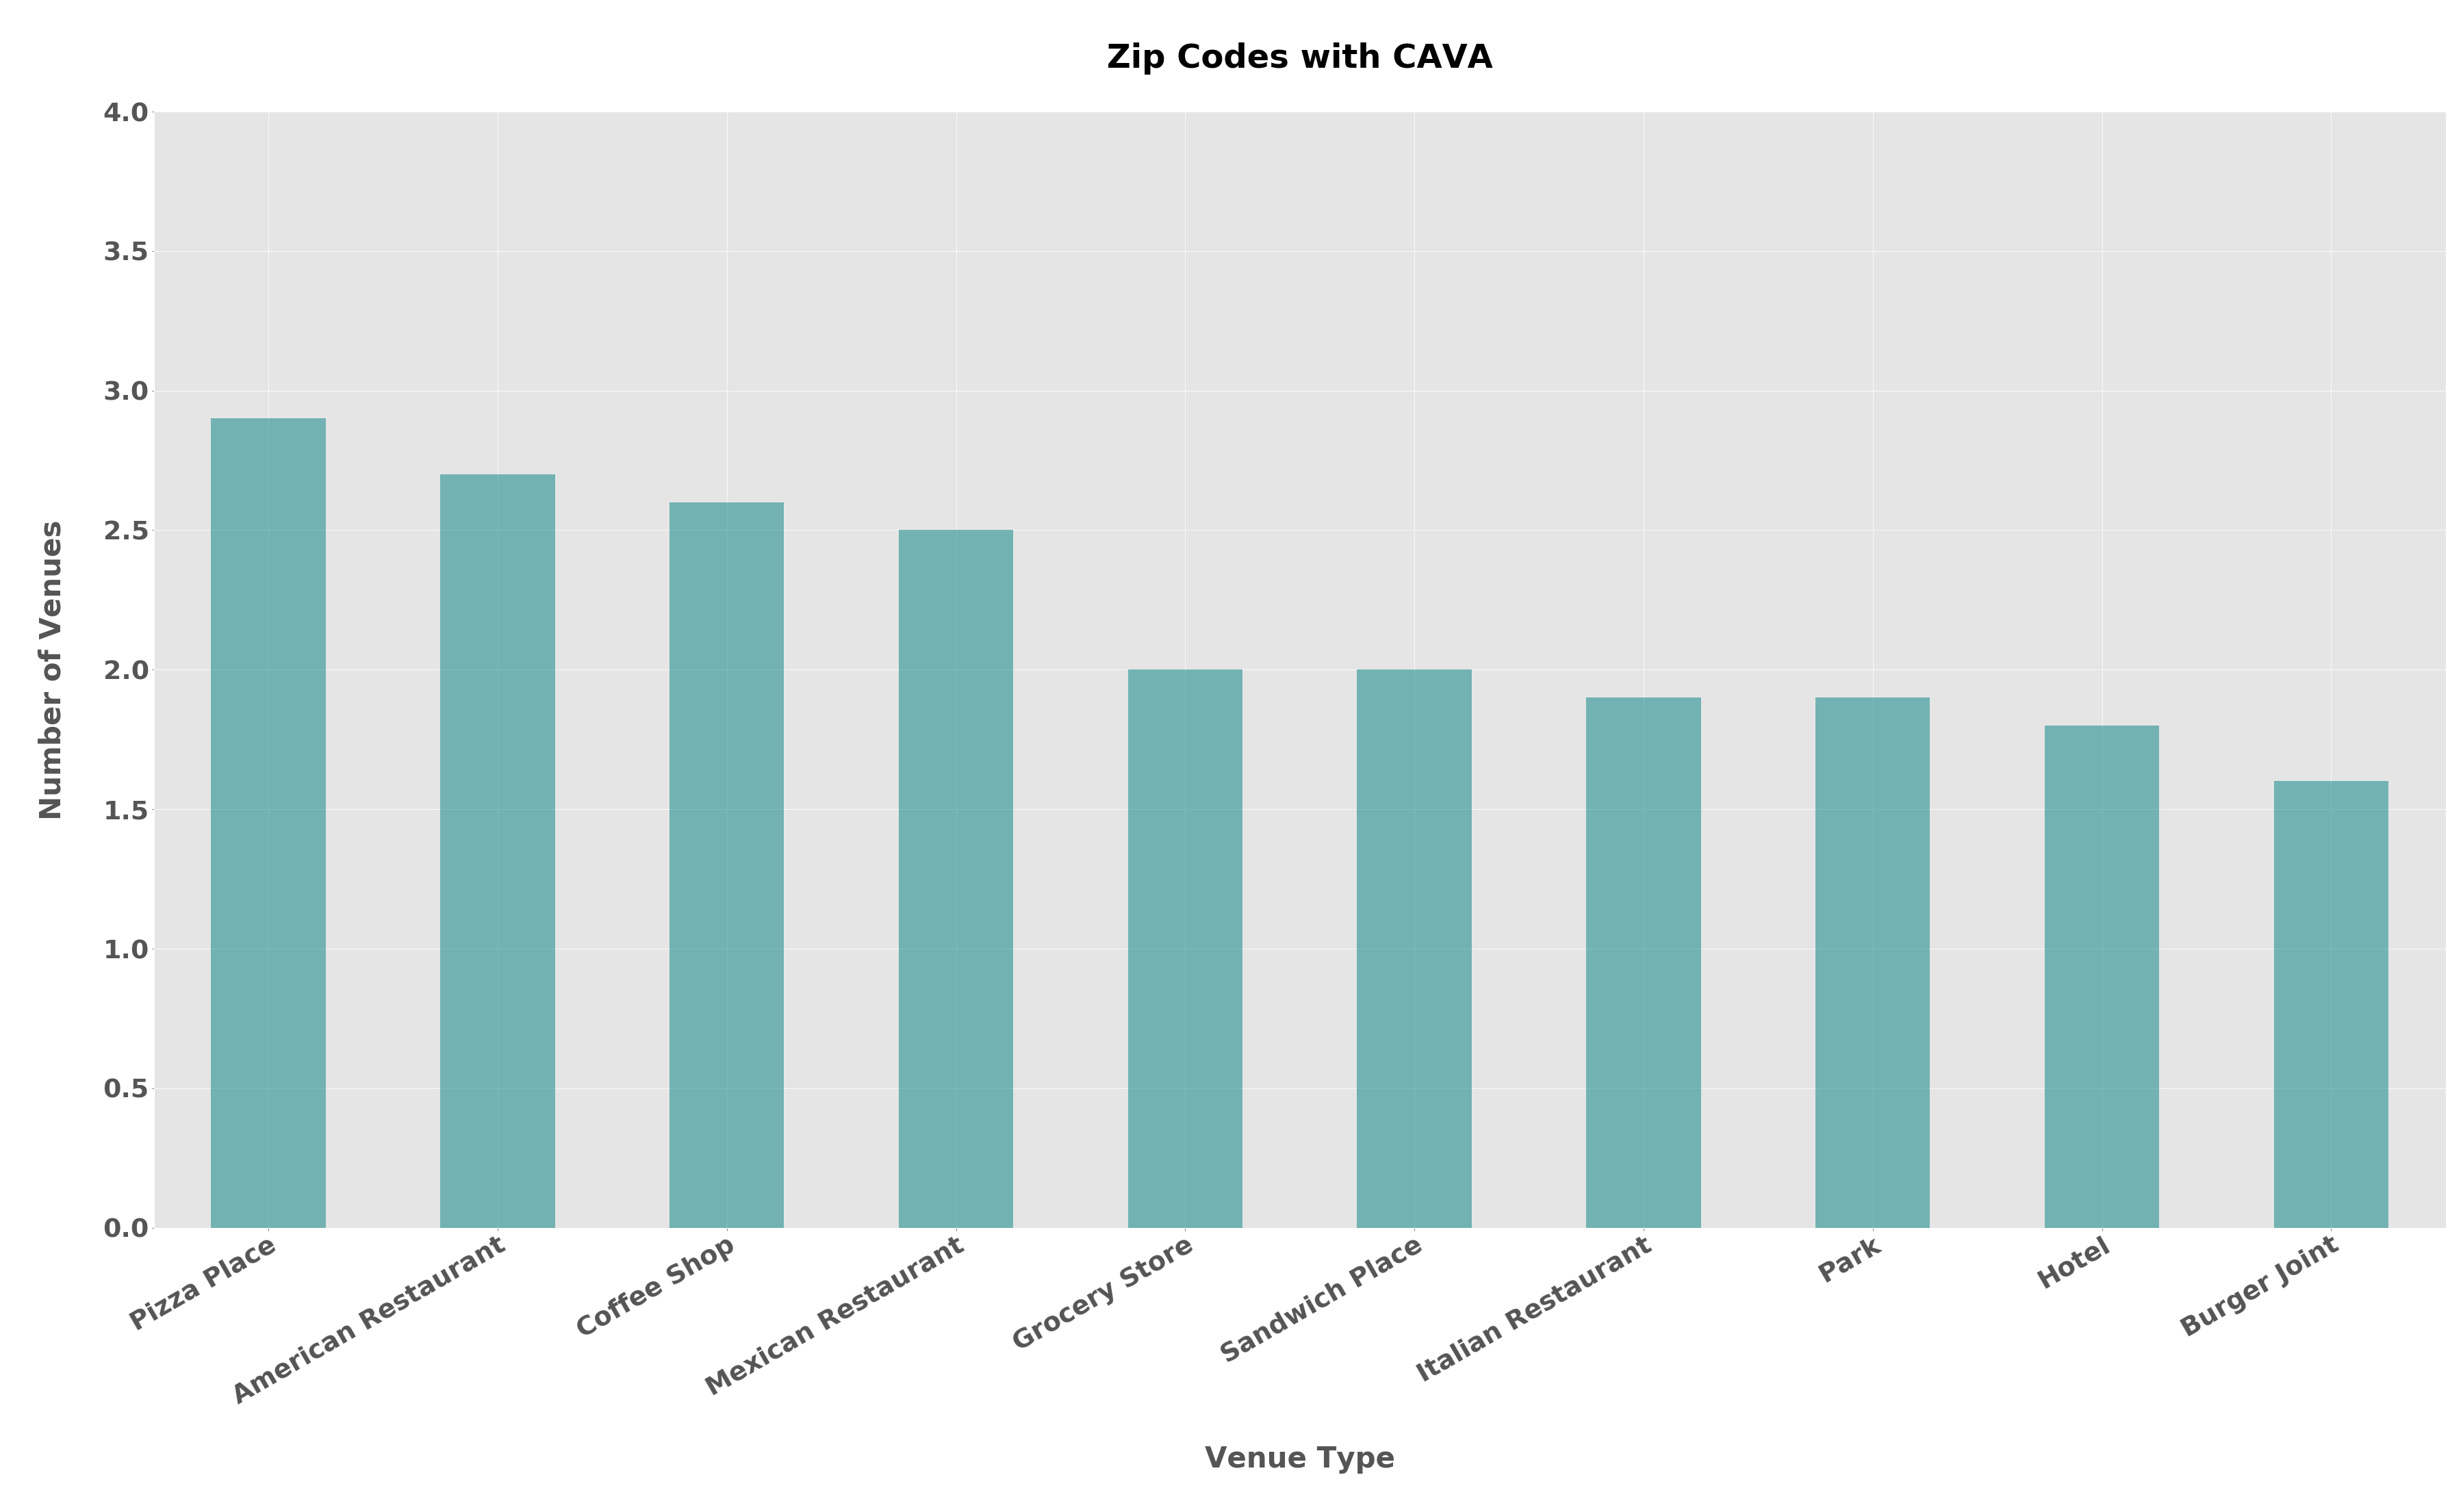

In [30]:
## Bar graph to show most popular venue type in zip codes with CAVA

explore_grouped_cavs.plot(kind = 'bar',
                          figsize = (60,30),
                          align = 'center',
                          color = 'teal',
                          alpha = 0.5,
                          legend = None)


plt.title('\nZip Codes with CAVA\n', fontsize = 48, weight = 'bold') # add title to the plot
plt.xlabel('\nVenue Type\n', fontsize = 42, weight = 'bold') # add to x-label to the plot
plt.xticks(rotation = 30, fontsize = 38, weight = 'bold', rotation_mode = 'anchor', ha = 'right')
plt.ylabel('\nNumber of Venues\n', fontsize = 42, weight = 'bold') # add y-label to the plot
plt.yticks(fontsize = 38, weight = 'bold')
plt.ylim(0,4)


plt.savefig('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/pop_vens_cava_bargraph.png', bbox_inches = 'tight')

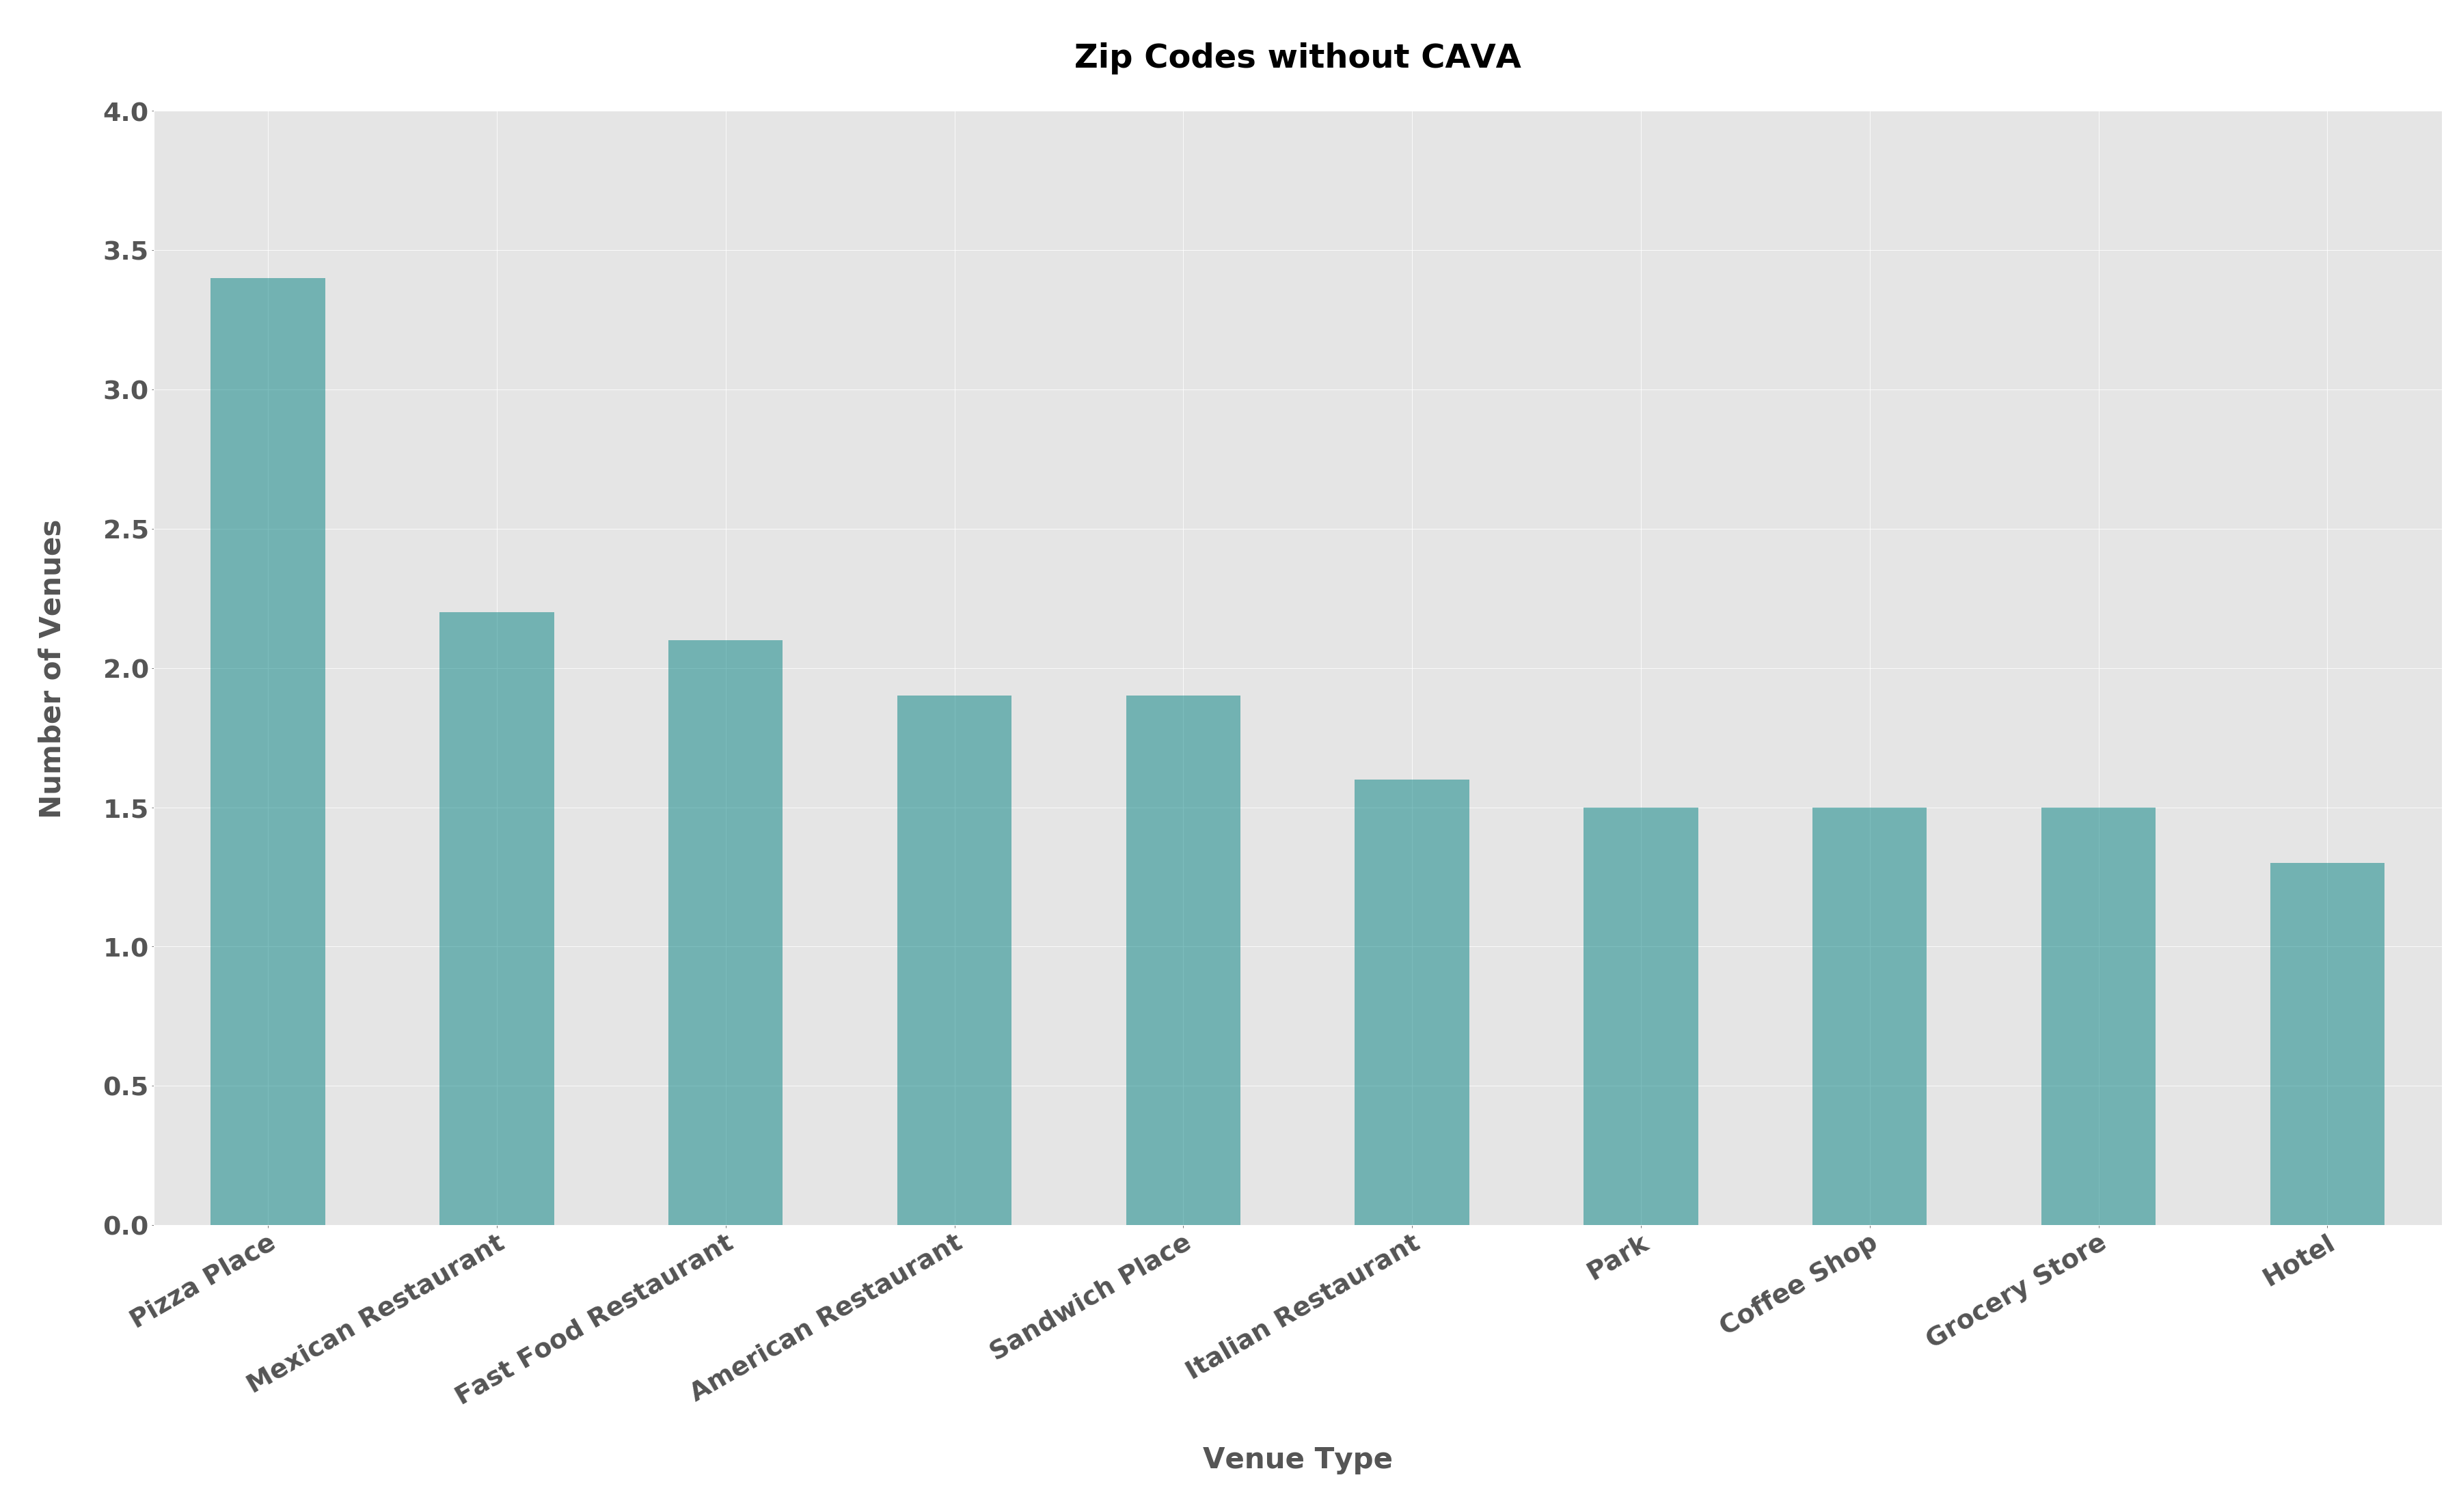

In [31]:
## Bar graph to show most popular venue type in zip codes without CAVA

explore_grouped_nocavs.plot(kind = 'bar',
                            figsize = (60,30),
                            align = 'center',
                            color = 'teal',
                            alpha = 0.5,
                            legend = None)


plt.title('\nZip Codes without CAVA\n', fontsize = 48, weight = 'bold') # add title to the plot
plt.xlabel('\nVenue Type\n', fontsize = 42, weight = 'bold') # add to x-label to the plot
plt.xticks(rotation = 30, fontsize = 38, weight = 'bold', rotation_mode = 'anchor', ha = 'right')
plt.ylabel('\nNumber of Venues\n', fontsize = 42, weight = 'bold') # add y-label to the plot
plt.yticks(fontsize = 38, weight = 'bold')
plt.ylim(0,4)


plt.savefig('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/pop_vens_nocava_bargraph.png', bbox_inches = 'tight')


#### 

# Drop Insignificant Venue Types and Any Remaining Collinear Venue Types from Training Dataframe

In [ ]:
#### Import needed libraries

In [32]:
## Standard libraries
import pandas as pd
import numpy as np

## Statistical significance test library
from scipy.stats import ttest_ind

## Collinearity assessment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Warnings output library
import warnings

## Confirm imports
print("\nLibraries imported.\n")


Libraries imported.



In [51]:
#### Modify output settings

In [33]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

## Confirm changes
print('\nSettings changed.\n')


Settings changed.



In [ ]:
#### Load training dataframe

In [48]:
## Load dataframe
near_vens_onehot_grouped_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_coded_grouped_venue_df.csv').drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', near_vens_onehot_grouped_df.shape, '\n', sep = '')
near_vens_onehot_grouped_df.head()


Dataframe shape: (445, 504)



,Has CAVA?,Zip Code,City,School,Capitol Building,Student Center,Dry Cleaner,Forest,Food Court,Pool Hall,Music School,Colombian Restaurant,Bakery,Australian Restaurant,Building,Record Shop,Farm,Market,Museum,Bus Line,Fast Food Restaurant,Indian Restaurant,National Park,Halal Restaurant,Outdoors & Recreation,Empanada Restaurant,Toy / Game Store,Home Service,Art Museum,Soccer Stadium,Women's Store,Concert Hall,Resort,Hookah Bar,Bath House,Multiplex,Board Shop,Fish & Chips Shop,Rest Area,Garden Center,Greek Restaurant,Train Station,Dive Bar,General Entertainment,Peruvian Restaurant,Mongolian Restaurant,Jazz Club,New American Restaurant,Beach,Pool,Beer Garden,Seafood Restaurant,Korean Restaurant,Mac & Cheese Joint,Baby Store,Assisted Living,Indonesian Restaurant,French Restaurant,English Restaurant,Travel Agency,Bubble Tea Shop,Pedestrian Plaza,Poke Place,Paella Restaurant,Spanish Restaurant,American Restaurant,Amphitheater,Laser Tag,Shipping Store,Laundromat,Golf Course,Zoo,Train,Organic Grocery,Shopping Mall,Garden,Light Rail Station,Arts & Entertainment,Taco Place,Theme Park,Beer Bar,Falafel Restaurant,Food & Drink Shop,Stables,Warehouse Store,Costume Shop,Gymnastics Gym,Art Gallery,Vegetarian / Vegan Restaurant,Aquarium,Shoe Store,Arepa Restaurant,Exhibit,German Restaurant,Sculpture Garden,Cafeteria,College Quad,Motorsports Shop,Dog Run,Advertising Agency,Furniture / Home Store,Country Dance Club,Brazilian Restaurant,Bridge,Waste Facility,Mattress Store,Lawyer,Hawaiian Restaurant,Sri Lankan Restaurant,Bed & Breakfast,Monument / Landmark,Department Store,High School,Roof Deck,Smoothie Shop,Lighthouse,Tennis Court,Deli / Bodega,Optical Shop,Farmers Market,State / Provincial Park,Outlet Store,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Polish Restaurant,Water Park,Pet Café,Radio Station,Health Food Store,Chinese Restaurant,Car Wash,Bike Trail,Pharmacy,Animal Shelter,Flower Shop,Nail Salon,Tattoo Parlor,College Academic Building,Other Repair Shop,Bay,Beach Bar,Eastern European Restaurant,Watch Shop,Scenic Lookout,Italian Restaurant,Hardware Store,Middle Eastern Restaurant,Clothing Store,Truck Stop,College Classroom,Business Service,Hotel,Gym / Fitness Center,Nature Preserve,Event Space,Baseball Field,Ski Lodge,Lingerie Store,Community Center,Shop & Service,Toll Booth,Liquor Store,Street Art,Insurance Office,Afghan Restaurant,Airport,Design Studio,African Restaurant,Photography Studio,Speakeasy,Pilates Studio,Neighborhood,Churrascaria,Boat or Ferry,Circus,Auto Workshop,Martial Arts School,Ski Area,Paintball Field,Check Cashing Service,Heliport,Sporting Goods Shop,Dessert Shop,Recycling Facility,Venezuelan Restaurant,Rental Service,Lighting Store,Hobby Shop,Pastry Shop,Irish Pub,College Rec Center,Bank,ATM,Music Venue,Breakfast Spot,Platform,Taiwanese Restaurant,Big Box Store,Burrito Place,Fair,Hotpot Restaurant,Ethiopian Restaurant,Buffet,Post Office,Chiropractor,Rock Climbing Spot,Office,Shabu-Shabu Restaurant,Weight Loss Center,Parking,Rental Car Location,Comfort Food Restaurant,Music Store,Courthouse,Supermarket,Performing Arts Venue,Gaming Cafe,Snack Place,Bar,Roller Rink,Arcade,Cosmetics Shop,Medical Center,Pizza Place,Diner,Recording Studio,Dutch Restaurant,Food Stand,Airport Service,Basketball Stadium,Tea Room,Drive-in Theater,Coffee Shop,Fruit & Vegetable Store,History Museum,Creperie,Skating Rink,Police Station,Soccer Field,Skate Park,Campground,Currency Exchange,Cheese Shop,Men's Store,Planetarium,Food Truck,Playground,Hunan Restaurant,Gas Station,Massage Studio,Indie Theater,RV Park,Residential Building (Apartment / Condo),Eye Doctor,Grocery Store,Karaoke Bar,Hostel,Beer Store,Doctor's Office,Swim School,Drugstore,Mobile Phone Shop,Opera House,Sake Bar,Leather Goods Store,Cantonese Restaurant,River,Jewish Restaurant,Sandwich Place,Spiritual Center,Sushi Restaurant,Jewelry Store,Kitchen Supply Store,Tennis Stadium,Café,Locksmith,College Basketball Court,College Cafeteria,Disc Golf,Scandinavian Restaurant,Persian Resta

In [ ]:
#### Perform T-tests to determine if number of venue types differs, on average, between CAVA zip codes and non-CAVA zip codes

In [49]:
## Create empty list to store venue types and corresponing t-test results
ttest_results_list = []
vars_to_test = near_vens_onehot_grouped_df.columns.tolist()[3:]

## Perform t-test for each venue type
for col in vars_to_test:
    cat1 = near_vens_onehot_grouped_df[near_vens_onehot_grouped_df['Has CAVA?'] == 1][col].astype(int)
    cat2 = near_vens_onehot_grouped_df[near_vens_onehot_grouped_df['Has CAVA?'] == 0][col].astype(int)
    pval = ttest_ind(cat1, cat2)[1]
    ttest_results_list.append([col, pval])
    
## Show some of the t-testing results
ttest_results_list[0:10]

## Create list of insignificant venue types to drop
# create empty list
drop_vars_list = []
# iterate through t-testing results list and, if p-value > 0.05, add to drop list
for var in ttest_results_list:
    if var[1] > 0.05:
        drop_vars_list.append(var[0])

## Report results
print('\nNumber of variables to drop: {}'.format(len(drop_vars_list)), '\n')
print('Sample of variables to drop: \n')
# show some of the variables to drop
for var in drop_vars_list[0:10]:
    print(var)
print()


Number of variables to drop: 376 

Sample of variables to drop: 

School
Student Center
Dry Cleaner
Forest
Pool Hall
Music School
Colombian Restaurant
Australian Restaurant
Building
Record Shop



In [46]:
#### Drop statistically insignificant venue types found above

In [51]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_coded_grouped_venue_df.csv', dtype = {'Zip Code' : str}).drop('Unnamed: 0', axis = 1)

## Record dataframe shape before drop
print('\nDataframe shape before drop: ', training_dataset.shape, '\n', sep = '')

## Record expected size of dataframe after drop
exp_row_num = len(training_dataset.columns) - len(drop_vars_list)

## Drop insignificant venue types
training_dataset.drop(drop_vars_list, axis = 1, inplace = True)

## Check dataframe prepped properly
print('Expected dataframe shape after drop: (445, {})'.format(exp_row_num))
print('Actual dataframe shape after drop:   {}'.format(training_dataset.shape), '\n', sep = '')
training_dataset.head()


Dataframe shape before drop: (445, 504)

Expected dataframe shape after drop: (445, 128)
Actual dataframe shape after drop:   (445, 128)



,Has CAVA?,Zip Code,City,Capitol Building,Food Court,Bakery,Museum,Fast Food Restaurant,Indian Restaurant,National Park,Toy / Game Store,Art Museum,Women's Store,Resort,Multiplex,Board Shop,Garden Center,Greek Restaurant,Dive Bar,New American Restaurant,Pool,Beer Garden,Seafood Restaurant,French Restaurant,Poke Place,American Restaurant,Shopping Mall,Garden,Taco Place,Beer Bar,Vegetarian / Vegan Restaurant,German Restaurant,Furniture / Home Store,Bridge,Monument / Landmark,Smoothie Shop,Deli / Bodega,Farmers Market,State / Provincial Park,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Pharmacy,Animal Shelter,Eastern European Restaurant,Scenic Lookout,Middle Eastern Restaurant,Hotel,Gym / Fitness Center,Neighborhood,Sporting Goods Shop,Rental Service,Bank,ATM,Music Venue,Ethiopian Restaurant,Buffet,Shabu-Shabu Restaurant,Courthouse,Performing Arts Venue,Cosmetics Shop,Basketball Stadium,Tea Room,Coffee Shop,Planetarium,Gas Station,Indie Theater,Grocery Store,Beer Store,Swim School,Mobile Phone Shop,Opera House,Sushi Restaurant,Jewelry Store,Café,College Basketball Court,Persian Restaurant,Plaza,Belgian Restaurant,Pie Shop,Science Museum,Movie Theater,Thrift / Vintage Store,Juice Bar,Electronics Store,Steakhouse,Cycle Studio,Fried Chicken Joint,Bookstore,Wine Bar,Japanese Restaurant,Flea Market,Pet Store,Gourmet Shop,Cocktail Bar,Russian Restaurant,Discount Store,Automotive Shop,Trail,Bagel Shop,Portuguese Restaurant,Wings Joint,Gastropub,Mediterranean Restaurant,Video Game Store,Yoga Studio,Spa,Donut Shop,Hotel Bar,Whisky Bar,Ice Cream Shop,Gym Pool,Tiki Bar,Gym,Convenience Store,Video Store,Salad Place,Dumpling Restaurant,Gluten-free Restaurant,Library,Wine Shop,Thai Restaurant,Outdoor Sculpture,Boutique,Modern European Restaurant,Field,Distillery,Burger Joint
0,0,1040,"Holyoke, MA",0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1085,"Westfield, MA",0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1201,"Pittsfield, MA",0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1420,"Fitchburg, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,2,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1453,"Leominster, MA",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0


In [48]:
#### Drop collinear variables from training dataset

In [52]:
## Record shape of training dataframe before drops
shape = training_dataset.shape

## Define variable to determine whether collinearity elimination should occur (0 = continue, 1 = stop)
keep_going = 0

## Define variable to keep track of progress through iterations
iters_completed = 0

## While needed (because variables with VIF > 10 still exist), continue collinearity elimination
while keep_going == 0:

    ## Get dataframe showing VIFs for all venue types that have not yet been dropped
    # create new dataframe
    vif_df = pd.DataFrame()
    # get portion of dataframe related to venue types (variables 0 - 2 are not variable types)
    X = training_dataset.iloc[:,3:] 
    # create variable that records each venue type
    vif_df["Variables"] = X.columns
    # calculate VIF for each venue type and assign as variable in row corresponding to venue type
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # get sub-dataframe showing only venue types with VIF > 10
    vif_drop_vars = vif_df[vif_df['VIF'] >= 10].sort_values(by = 'VIF', ascending = False)['Variables'].tolist()
    # if there are venue types in that sub-dataframe, elimate the one with the biggest VIF from the training dataframe
    if len(vif_drop_vars) > 0:
        drop_var = vif_drop_vars[0]
        training_dataset.drop(drop_var, axis = 1, inplace = True)
        
        # show the number of iterations performed (to demonstrate working program and number of features eliminated)
        iters_completed += 1
        print('Iterations completed: {}'.format(iters_completed), end = '\r')
    
    # if there is no venue with VIF > 2.5, stop processing VIFs
    else:
        keep_going = 1
    
## Show final resulting training dataset
print('\n\nDataframe shape before drop: {}'.format(shape), '\n')

print('Expected dataframe shape after drop: (445, {})'.format(shape[1] - iters_completed))
print('Actual dataframe shape after drop:   {}'.format(training_dataset.shape), '\n', sep = '')
training_dataset.head()

Iterations completed: 2

Dataframe shape before drop: (445, 128) 

Expected dataframe shape after drop: (445, 126)
Actual dataframe shape after drop:   (445, 126)



,Has CAVA?,Zip Code,City,Capitol Building,Food Court,Bakery,Museum,Fast Food Restaurant,Indian Restaurant,National Park,Toy / Game Store,Art Museum,Women's Store,Resort,Multiplex,Board Shop,Garden Center,Greek Restaurant,Dive Bar,New American Restaurant,Pool,Beer Garden,Seafood Restaurant,French Restaurant,Poke Place,American Restaurant,Shopping Mall,Garden,Taco Place,Beer Bar,Vegetarian / Vegan Restaurant,German Restaurant,Furniture / Home Store,Bridge,Monument / Landmark,Smoothie Shop,Deli / Bodega,Farmers Market,State / Provincial Park,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Pharmacy,Animal Shelter,Eastern European Restaurant,Scenic Lookout,Middle Eastern Restaurant,Hotel,Gym / Fitness Center,Neighborhood,Sporting Goods Shop,Rental Service,Bank,ATM,Music Venue,Ethiopian Restaurant,Buffet,Shabu-Shabu Restaurant,Performing Arts Venue,Cosmetics Shop,Basketball Stadium,Tea Room,Coffee Shop,Planetarium,Gas Station,Indie Theater,Grocery Store,Beer Store,Swim School,Mobile Phone Shop,Opera House,Sushi Restaurant,Jewelry Store,Café,College Basketball Court,Persian Restaurant,Plaza,Belgian Restaurant,Pie Shop,Science Museum,Movie Theater,Thrift / Vintage Store,Juice Bar,Electronics Store,Steakhouse,Cycle Studio,Fried Chicken Joint,Bookstore,Wine Bar,Japanese Restaurant,Flea Market,Pet Store,Gourmet Shop,Cocktail Bar,Russian Restaurant,Discount Store,Automotive Shop,Trail,Bagel Shop,Portuguese Restaurant,Wings Joint,Gastropub,Mediterranean Restaurant,Video Game Store,Yoga Studio,Spa,Donut Shop,Hotel Bar,Whisky Bar,Ice Cream Shop,Gym Pool,Gym,Convenience Store,Video Store,Salad Place,Dumpling Restaurant,Gluten-free Restaurant,Library,Wine Shop,Thai Restaurant,Outdoor Sculpture,Boutique,Modern European Restaurant,Field,Distillery,Burger Joint
0,0,1040,"Holyoke, MA",0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1085,"Westfield, MA",0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1201,"Pittsfield, MA",0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1420,"Fitchburg, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1453,"Leominster, MA",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#### Save updated training dataframe

In [53]:
## Save dataframe
training_dataset.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_training_df.csv')

## Confirm dataframe saved
print('\nDataset saved.\n')


Dataset saved.



#### 

# Develop Optimal Logistic Regression Model

In [ ]:
#### Import needed libraries

In [32]:
## Standard libraries
import pandas as pd
import numpy as np

## Log Reg model libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

## Warnings output library
import warnings

## Math library
import math

## Confirm imports
print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
#### Change warning and display settings to eliminate warnings and show all rows & columns

In [33]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Confirm setting of options
print('\nOptions set as desired.\n')


Options set as desired.



In [ ]:
#### Load the training dataset

In [34]:
## Load training dataset
training_dataset = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_training_df.csv').drop('Unnamed: 0', axis = 1)

## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()


Dataframe shape: (445, 126)



,Has CAVA?,Zip Code,City,Capitol Building,Food Court,Bakery,Museum,Fast Food Restaurant,Indian Restaurant,National Park,Toy / Game Store,Art Museum,Women's Store,Resort,Multiplex,Board Shop,Garden Center,Greek Restaurant,Dive Bar,New American Restaurant,Pool,Beer Garden,Seafood Restaurant,French Restaurant,Poke Place,American Restaurant,Shopping Mall,Garden,Taco Place,Beer Bar,Vegetarian / Vegan Restaurant,German Restaurant,Furniture / Home Store,Bridge,Monument / Landmark,Smoothie Shop,Deli / Bodega,Farmers Market,State / Provincial Park,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Pharmacy,Animal Shelter,Eastern European Restaurant,Scenic Lookout,Middle Eastern Restaurant,Hotel,Gym / Fitness Center,Neighborhood,Sporting Goods Shop,Rental Service,Bank,ATM,Music Venue,Ethiopian Restaurant,Buffet,Shabu-Shabu Restaurant,Performing Arts Venue,Cosmetics Shop,Basketball Stadium,Tea Room,Coffee Shop,Planetarium,Gas Station,Indie Theater,Grocery Store,Beer Store,Swim School,Mobile Phone Shop,Opera House,Sushi Restaurant,Jewelry Store,Café,College Basketball Court,Persian Restaurant,Plaza,Belgian Restaurant,Pie Shop,Science Museum,Movie Theater,Thrift / Vintage Store,Juice Bar,Electronics Store,Steakhouse,Cycle Studio,Fried Chicken Joint,Bookstore,Wine Bar,Japanese Restaurant,Flea Market,Pet Store,Gourmet Shop,Cocktail Bar,Russian Restaurant,Discount Store,Automotive Shop,Trail,Bagel Shop,Portuguese Restaurant,Wings Joint,Gastropub,Mediterranean Restaurant,Video Game Store,Yoga Studio,Spa,Donut Shop,Hotel Bar,Whisky Bar,Ice Cream Shop,Gym Pool,Gym,Convenience Store,Video Store,Salad Place,Dumpling Restaurant,Gluten-free Restaurant,Library,Wine Shop,Thai Restaurant,Outdoor Sculpture,Boutique,Modern European Restaurant,Field,Distillery,Burger Joint
0,0,1040,"Holyoke, MA",0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1085,"Westfield, MA",0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1201,"Pittsfield, MA",0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1420,"Fitchburg, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1453,"Leominster, MA",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#### Optimize a logistic regression model using RFE

In [35]:
## Use RFE selector to pick best variable combination for every possible combination # (i.e., for best combo of 1 variable, of 2 variables, 3 variales, etc.)
## Fit and score logreg model for each best combination (will pick the variable combination with the best score)

# define X and y and preprocess
X = training_dataset.iloc[:,3:]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

# define predictors in dataset
predictors = training_dataset.iloc[:,3:].columns

# test using number of features between 1 and the highest maximum for which the selector only picks statistically significant variables
min_features = 1
max_features = 9  # 9 is the highest number of predictors possible before the selector picks a combination that are not all statistically significant

# define prediction model
reg_mod = LogisticRegression(C = 0.01)

# make list of scoring for each n number of predictors
logreg_scores_list = []

# keep track of iteration through number of features tested
completed = 0
total = max_features

# for each number of features to test, find best feature combination and score for that feature set
for n in range(min_features, max_features + 1):
    
    # get list of varibles picked by the selector
    selector = RFE(reg_mod, n_features_to_select = n).fit(X, y)
    keep_vars = np.asarray(predictors)[selector.support_]
    
    X_sub = np.asarray(training_dataset[keep_vars])
    X_sub = preprocessing.StandardScaler().fit(X_sub).transform(X_sub)

    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(reg_mod, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    logreg_scores_list.append([n, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper, keep_vars])
    
    # show progress through iterations
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')


## Create dataframe of all the evaluation parameters
# Make scoring list into dataframe
logreg_scores_df = pd.DataFrame(logreg_scores_list, columns = ['# Predictors',
                                                               'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                               'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                               'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI',
                                                               'Predictors'])

## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
logreg_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', '# Predictors'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# get number of predictors for best model
logreg_final_n = logreg_scores_df['# Predictors'].values[0]

# get cross-validated score for best model
logreg_final_score = logreg_scores_df['Score'].values[0]
logreg_final_score_lower_CI = logreg_scores_df['Score Lower 95% CI'].values[0]
logreg_final_score_upper_CI = logreg_scores_df['Score Upper 95% CI'].values[0]

# get cross-validated ppv for best model
logreg_final_ppv = logreg_scores_df['PPV'].values[0]
logreg_final_ppv_lower_CI = logreg_scores_df['PPV Lower 95% CI'].values[0]
logreg_final_ppv_upper_CI = logreg_scores_df['PPV Upper 95% CI'].values[0]

# get cross-validated sensitivity for best model
logreg_final_sense = logreg_scores_df['Sensitivity'].values[0]
logreg_final_sense_lower_CI  = logreg_scores_df['Sensitivity Lower 95% CI'].values[0]
logreg_final_sense_upper_CI = logreg_scores_df['Sensitivity Upper 95% CI'].values[0]

# get predictors used in optimal model
logreg_final_kept_vars = logreg_scores_df['Predictors'].values[0]


## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nBest # of predictors:                {}'.format(logreg_final_n))
print()

print('Final cross-validated score:         {}'.format(logreg_final_score))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(logreg_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(logreg_final_sense))
print('Corresponding lower 95% CI:          {}'.format(logreg_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(logreg_final_sense_upper_CI))
print()

print('Best predictors:')
[print(' -x{}:'.format(i+1), pred) for i, pred in enumerate(logreg_final_kept_vars)]
print()

## Show statistical significant of variables used in final best model
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

fitted_mod = sm.Logit(y, X).fit()

print(fitted_mod.summary2())

## Show scores dataframe
logreg_scores_df.head(10)

Percent completed: 100%                                                     

Best # of predictors:                9

Final cross-validated score:         0.8
Corresponding lower 95% CI:          0.78
Corresponding upper 95% CI:          0.82

Final cross-validated PPV:           0.74
Corresponding lower 95% CI:          0.61
Corresponding upper 95% CI:          0.87

Final cross-validated Sensitivity:   0.2
Corresponding lower 95% CI:          0.14
Corresponding upper 95% CI:          0.26

Best predictors:
 -x1: Garden Center
 -x2: Shopping Mall
 -x3: Smoothie Shop
 -x4: Pharmacy
 -x5: Coffee Shop
 -x6: Sushi Restaurant
 -x7: Gourmet Shop
 -x8: Discount Store
 -x9: Salad Place

Optimization terminated successfully.
         Current function value: 0.547568
         Iterations 6
                        Results: Logit
Model:              Logit            Pseudo R-squared: -0.022  
Dependent Variable: Has CAVA?        AIC:              505.3351
Date:               2020-08-30 16:44 BIC: 

,# Predictors,Score,Score Lower 95% CI,Score Upper 95% CI,PPV,PPV Lower 95% CI,PPV Upper 95% CI,Sensitivity,Sensitivity Lower 95% CI,Sensitivity Upper 95% CI,Predictors
8,9,0.80,0.78,0.82,0.74,0.61,0.87,0.20,0.14,0.26,"[Garden Center, Shopping Mall, Smoothie Shop, ..."
7,8,0.80,0.78,0.82,0.75,0.58,0.92,0.17,0.11,0.23,"[Garden Center, Shopping Mall, Pharmacy, Coffe..."
6,7,0.79,0.77,0.81,0.60,0.41,0.79,0.14,0.08,0.20,"[Shopping Mall, Pharmacy, Coffee Shop, Sushi R..."
5,6,0.81,0.78,0.84,0.65,0.40,0.90,0.21,0.08,0.34,"[Shopping Mall, Pharmacy, Coffee Shop, Gourmet..."
4,5,0.80,0.78,0.82,0.60,0.33,0.87,0.14,0.07,0.21,"[Shopping Mall, Pharmacy, Coffee Shop, Discoun..."
3,4,0.78,0.76,0.80,0.57,0.29,0.85,0.09,0.04,0.14,"[Pharmacy, Coffee Shop, Discount Store, Salad ..."
1,2,0.78,0.76,0.80,0.45,0.16,0.74,0.07,0.01,0.13,"[Discount Store, Salad Place]"
0,1,0.78,0.76,0.80,0.45,0.16,0.74,0.07,0.01,0.13,[Salad Place]
2,3,0.78,0.76,0.80,0.42,0.13,0.71,0.07,0.01,0.13,"[Coffee Shop, Discount Store, Salad Place]"


#### 

# Develop Optimal SVC Model

In [ ]:
#### Import needed packages/libraries

In [36]:
## Standard libraries
import pandas as pd
import numpy as np

## Feature selection library
from sklearn.feature_selection import RFE

## SVC training libraries
from sklearn import preprocessing
from sklearn.svm import SVC

## Model evaluation libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Warnings ouput library
import warnings

## Basic math library
import math

## Confirm imports
print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
#### Change settings to eliminate warnings and show all dataframe rows/columns

In [37]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Confirm options setting
print('\nOptions set as desired.\n')


Options set as desired.



In [ ]:
#### Load the training dataset

In [38]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_training_df.csv').drop('Unnamed: 0', axis = 1)

## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.sort_values(by = "City").head()


Dataframe shape: (445, 126)



,Has CAVA?,Zip Code,City,Capitol Building,Food Court,Bakery,Museum,Fast Food Restaurant,Indian Restaurant,National Park,Toy / Game Store,Art Museum,Women's Store,Resort,Multiplex,Board Shop,Garden Center,Greek Restaurant,Dive Bar,New American Restaurant,Pool,Beer Garden,Seafood Restaurant,French Restaurant,Poke Place,American Restaurant,Shopping Mall,Garden,Taco Place,Beer Bar,Vegetarian / Vegan Restaurant,German Restaurant,Furniture / Home Store,Bridge,Monument / Landmark,Smoothie Shop,Deli / Bodega,Farmers Market,State / Provincial Park,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Pharmacy,Animal Shelter,Eastern European Restaurant,Scenic Lookout,Middle Eastern Restaurant,Hotel,Gym / Fitness Center,Neighborhood,Sporting Goods Shop,Rental Service,Bank,ATM,Music Venue,Ethiopian Restaurant,Buffet,Shabu-Shabu Restaurant,Performing Arts Venue,Cosmetics Shop,Basketball Stadium,Tea Room,Coffee Shop,Planetarium,Gas Station,Indie Theater,Grocery Store,Beer Store,Swim School,Mobile Phone Shop,Opera House,Sushi Restaurant,Jewelry Store,Café,College Basketball Court,Persian Restaurant,Plaza,Belgian Restaurant,Pie Shop,Science Museum,Movie Theater,Thrift / Vintage Store,Juice Bar,Electronics Store,Steakhouse,Cycle Studio,Fried Chicken Joint,Bookstore,Wine Bar,Japanese Restaurant,Flea Market,Pet Store,Gourmet Shop,Cocktail Bar,Russian Restaurant,Discount Store,Automotive Shop,Trail,Bagel Shop,Portuguese Restaurant,Wings Joint,Gastropub,Mediterranean Restaurant,Video Game Store,Yoga Studio,Spa,Donut Shop,Hotel Bar,Whisky Bar,Ice Cream Shop,Gym Pool,Gym,Convenience Store,Video Store,Salad Place,Dumpling Restaurant,Gluten-free Restaurant,Library,Wine Shop,Thai Restaurant,Outdoor Sculpture,Boutique,Modern European Restaurant,Field,Distillery,Burger Joint
238,1,22314,"Alexandria, VA",0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,2,0,0,3,3,0,5,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,1,1,2,0,0,0,3,0,0,0,5,0,0,0,0,1,0,0,0,1,2,0,1,1,0,0,0
239,1,22315,"Alexandria, VA",0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,2,3,0,1,0,0,0,3,0,0,1,2,1,0,0,0,0,0,0,0,0,1,0,2,0,0,0,1,1,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,1,0,2,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,3,0,0,0,0,0,1
237,1,22305,"Alexandria, VA",0,0,3,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,2,1,0,0,4,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,3,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,1,0,2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,3,0,0,0,0,0,0,0,2,0,1,0,0,0,5
236,0,22304,"Alexandria, VA",0,0,4,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,4,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,1,0,0,4,3,0,1,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,2,2,0,0,3,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0
144,0,18104,"Allentown, PA",0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,2,0,0,2,0,0,4,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,2,0,0,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#### Develop the optimal model

In [65]:
## Fit the selector across range of n features

# define X and y and preprocess
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

# define predictors in dataset
predictors = training_dataset.loc[:,logreg_final_kept_vars].columns

# test using number of features between 1 and all of them
min_features = 1
max_features = len(predictors)  # the model performs poorly after 100 variables

# define prediction model
svc_mod = SVC(kernel = 'linear')

# make list of scoring for each n number of predictors
svc_scores_list = []

# keep track of iteration through number of features tested
completed = 0
total = max_features

# for each number of features to test, find best feature set and score for that feature set
for n in range(min_features, max_features + 1):
    selector = RFE(svc_mod, n_features_to_select = n).fit(X, y)
    keep_vars = np.asarray(predictors[selector.support_])
    
    X_sub = training_dataset[keep_vars]
    X_sub = preprocessing.StandardScaler().fit(X_sub).transform(X_sub)
    
    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(svc_mod, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    svc_scores_list.append([n, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper, keep_vars])
    
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')


    
## Create dataframe of all the evaluation parameters
# make scoring list into dataframe
svc_scores_df = pd.DataFrame(svc_scores_list, columns = ['# Predictors',
                                                         'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                         'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                         'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI',
                                                         'Predictors'])


## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
svc_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', '# Predictors'], ascending = False, inplace = True)


## Get values from top row after sorting (top row =  best model)
# get number of predictors for best model
svc_final_n = svc_scores_df['# Predictors'].values[0]

# get cross-validated score for best model
svc_final_score = svc_scores_df['Score'].values[0]
svc_final_score_lower_CI = svc_scores_df['Score Lower 95% CI'].values[0]
svc_final_score_upper_CI = svc_scores_df['Score Upper 95% CI'].values[0]

# get cross-validated ppv for best model
svc_final_ppv = svc_scores_df['PPV'].values[0]
svc_final_ppv_lower_CI = svc_scores_df['PPV Lower 95% CI'].values[0]
svc_final_ppv_upper_CI = svc_scores_df['PPV Upper 95% CI'].values[0]

# get cross-validated sensitivity for best model
svc_final_sense = svc_scores_df['Sensitivity'].values[0]
svc_final_sense_lower_CI  = svc_scores_df['Sensitivity Lower 95% CI'].values[0]
svc_final_sense_upper_CI = svc_scores_df['Sensitivity Upper 95% CI'].values[0]

# get predictors used in optimal model
svc_final_kept_vars = svc_scores_df['Predictors'].values[0]


## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nBest # of predictors:                {}'.format(svc_final_n))
print()

print('Final cross-validated score:         {}'.format(svc_final_score))
print('Corresponding lower 95% CI:          {}'.format(svc_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(svc_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(svc_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(svc_final_sense))
print('Corresponding lower 95% CI:          {}'.format(svc_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(svc_final_sense_upper_CI))
print()

print('Best predictors:')
[print(' -', pred) for pred in svc_final_kept_vars]
print()


## Show dataframe
svc_scores_df.head()

Percent completed: 100%                                                     

Best # of predictors:                7

Final cross-validated score:         0.84
Corresponding lower 95% CI:          0.81
Corresponding upper 95% CI:          0.87

Final cross-validated PPV:           0.74
Corresponding lower 95% CI:          0.64
Corresponding upper 95% CI:          0.84

Final cross-validated Sensitivity:   0.49
Corresponding lower 95% CI:          0.39
Corresponding upper 95% CI:          0.59

Best predictors:
 - Garden Center
 - Shopping Mall
 - Smoothie Shop
 - Coffee Shop
 - Gourmet Shop
 - Discount Store
 - Salad Place



,# Predictors,Score,Score Lower 95% CI,Score Upper 95% CI,PPV,PPV Lower 95% CI,PPV Upper 95% CI,Sensitivity,Sensitivity Lower 95% CI,Sensitivity Upper 95% CI,Predictors
6,7,0.84,0.81,0.87,0.74,0.64,0.84,0.49,0.39,0.59,"[Garden Center, Shopping Mall, Smoothie Shop, ..."
7,8,0.84,0.82,0.86,0.73,0.63,0.83,0.48,0.39,0.57,"[Garden Center, Shopping Mall, Smoothie Shop, ..."
8,9,0.84,0.81,0.87,0.70,0.59,0.81,0.48,0.38,0.58,"[Garden Center, Shopping Mall, Smoothie Shop, ..."
5,6,0.83,0.80,0.86,0.71,0.59,0.83,0.44,0.35,0.53,"[Shopping Mall, Smoothie Shop, Coffee Shop, Go..."
4,5,0.83,0.80,0.86,0.70,0.57,0.83,0.43,0.32,0.54,"[Shopping Mall, Coffee Shop, Gourmet Shop, Dis..."


#### 

# Develop Optimal KNN Model

In [ ]:
#### Import needed libraries

In [66]:
## Standard libraries
import pandas as pd
import numpy as np

## KNN training libraries
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

## Model evaluation libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Warnings settings library
import warnings

## Basic math library
import math

## Plotting library
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
#### Change settings to avoid warning messages and improve output formats

In [67]:
## Eliminate 'zerodivide' warning
warnings.filterwarnings('ignore')

####
## Set to show all rows and columns in a dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('\nOptions set as desired.\n')


Options set as desired.



In [ ]:
#### Load and prepare the data

In [39]:
## Load dataset
training_dataset = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_training_df.csv').drop('Unnamed: 0', axis = 1)

## Drop any venue type that does not occur for any CAVA location
grouped_training_df = training_dataset.groupby(by = 'Has CAVA?').sum().drop(0)

for col in grouped_training_df.columns.tolist():
    if grouped_training_df[col].values[0] == 0:
        training_dataset.drop(col, axis = 1, inplace = True)

## Check that dataframe prepped properly
print('\nDataframe shape: ', training_dataset.shape, '\n', sep = '')
training_dataset.head()


Dataframe shape: (445, 123)



,Has CAVA?,Zip Code,City,Capitol Building,Food Court,Bakery,Museum,Fast Food Restaurant,Indian Restaurant,National Park,Toy / Game Store,Art Museum,Women's Store,Resort,Multiplex,Board Shop,Garden Center,Greek Restaurant,Dive Bar,New American Restaurant,Pool,Beer Garden,Seafood Restaurant,French Restaurant,Poke Place,American Restaurant,Shopping Mall,Garden,Taco Place,Beer Bar,Vegetarian / Vegan Restaurant,German Restaurant,Furniture / Home Store,Bridge,Monument / Landmark,Smoothie Shop,Deli / Bodega,Farmers Market,State / Provincial Park,Cupcake Shop,Pakistani Restaurant,Chocolate Shop,Pharmacy,Animal Shelter,Eastern European Restaurant,Scenic Lookout,Middle Eastern Restaurant,Hotel,Gym / Fitness Center,Neighborhood,Sporting Goods Shop,Bank,ATM,Music Venue,Ethiopian Restaurant,Shabu-Shabu Restaurant,Performing Arts Venue,Cosmetics Shop,Basketball Stadium,Tea Room,Coffee Shop,Planetarium,Gas Station,Indie Theater,Grocery Store,Beer Store,Swim School,Mobile Phone Shop,Opera House,Sushi Restaurant,Jewelry Store,Café,College Basketball Court,Persian Restaurant,Plaza,Belgian Restaurant,Pie Shop,Science Museum,Movie Theater,Thrift / Vintage Store,Juice Bar,Electronics Store,Steakhouse,Cycle Studio,Fried Chicken Joint,Bookstore,Wine Bar,Japanese Restaurant,Pet Store,Gourmet Shop,Cocktail Bar,Russian Restaurant,Discount Store,Automotive Shop,Trail,Bagel Shop,Portuguese Restaurant,Wings Joint,Gastropub,Mediterranean Restaurant,Video Game Store,Yoga Studio,Spa,Donut Shop,Hotel Bar,Whisky Bar,Ice Cream Shop,Gym Pool,Gym,Convenience Store,Video Store,Salad Place,Dumpling Restaurant,Gluten-free Restaurant,Library,Wine Shop,Thai Restaurant,Outdoor Sculpture,Boutique,Modern European Restaurant,Field,Distillery,Burger Joint
0,0,1040,"Holyoke, MA",0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1085,"Westfield, MA",0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1201,"Pittsfield, MA",0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1420,"Fitchburg, MA",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,2,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1453,"Leominster, MA",0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#### Train and score the model across a different ks

In [69]:
# Define X and y and preprocess
X = training_dataset.loc[:,logreg_final_kept_vars]
y = training_dataset['Has CAVA?']
X = preprocessing.StandardScaler().fit(X).transform(X)

## Initialize list to keep track of scores for each k
knn_scores_list = []

## Initialize variables to keep track of progress through iterations
completed = 0
total = len(training_dataset.loc[:,logreg_final_kept_vars].columns)

## For each k possible, calculate score of knn model
for k in range(1, total):
    
    # define model
    knn = KNeighborsClassifier(k)
    
    # calculate cross-validated score for current set of predictors
    cvs_score = cross_val_score(knn, X = X_sub, y = y, cv = 10)
    score = round(cvs_score.mean(), 2)
    score_95CI_lower = round(score - (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    score_95CI_upper = round(score + (cvs_score.std()/math.sqrt(10) * 1.96), 2)
    
    # calculate cross-validated ppv (precision)
    cvs_prec = cross_val_score(knn, X = X_sub, y = y, cv = 10, scoring = 'precision')
    prec = round(cvs_prec.mean(), 2)
    prec_95CI_lower = round(prec - (cvs_prec.std()/math.sqrt(10) * 1.96), 2)
    prec_95CI_upper = round(prec + (cvs_prec.std()/math.sqrt(10) * 1.96), 2)

    # calculate cross-validated sensitivity (recall)   
    cvs_sense = cross_val_score(knn, X = X_sub, y = y, cv = 10, scoring = 'recall')
    sense = round(cvs_sense.mean(), 2)
    sense_95CI_lower = round(sense - (cvs_sense.std()/math.sqrt(10) * 1.96), 2)
    sense_95CI_upper = round(sense + (cvs_sense.std()/math.sqrt(10) * 1.96), 2)

    # add all values to score list
    knn_scores_list.append([k, score, score_95CI_lower, score_95CI_upper, prec, prec_95CI_lower, prec_95CI_upper, sense, sense_95CI_lower, sense_95CI_upper])
    
    # report progress through iterations
    completed += 1
    print('Percent completed: {:%}'.format(completed / total), end = '\r')

## Create dataframe of all the evaluation parameters
# make scoring list into dataframe
knn_scores_df = pd.DataFrame(knn_scores_list, columns = ['K',
                                                         'Score', 'Score Lower 95% CI', 'Score Upper 95% CI',
                                                         'PPV', 'PPV Lower 95% CI', 'PPV Upper 95% CI',
                                                         'Sensitivity', 'Sensitivity Lower 95% CI', 'Sensitivity Upper 95% CI'])

## Sort dataframe from highest to lowest in this order of levels in the below order (PPV is most important; Sensitivity is then most important)
knn_scores_df.sort_values(by = ['PPV Lower 95% CI', 'Sensitivity Lower 95% CI', 'K'], ascending = False, inplace = True)

## Get values from top row after sorting (top row =  best model)
# get number of predictors for best model
knn_final_k = knn_scores_df['K'].values[0]

# get cross-validated score for best model
knn_final_score = knn_scores_df['Score'].values[0]
knn_final_score_lower_CI = knn_scores_df['Score Lower 95% CI'].values[0]
knn_final_score_upper_CI = knn_scores_df['Score Upper 95% CI'].values[0]

# get cross-validated ppv for best model
knn_final_ppv = knn_scores_df['PPV'].values[0]
knn_final_ppv_lower_CI = knn_scores_df['PPV Lower 95% CI'].values[0]
knn_final_ppv_upper_CI = knn_scores_df['PPV Upper 95% CI'].values[0]

# get cross-validated sensitivity for best model
knn_final_sense = knn_scores_df['Sensitivity'].values[0]
knn_final_sense_lower_CI  = knn_scores_df['Sensitivity Lower 95% CI'].values[0]
knn_final_sense_upper_CI = knn_scores_df['Sensitivity Upper 95% CI'].values[0]


## Print out scoring metrics for optimal model
print('\rPercent completed: 100%                                                     ')

print('\nFinal K:                             {}'.format(knn_final_k))
print()

print('Final cross-validated score:         {}'.format(knn_final_score))
print('Corresponding lower 95% CI:          {}'.format(knn_final_score_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_score_upper_CI))
print()

print('Final cross-validated PPV:           {}'.format(knn_final_ppv))
print('Corresponding lower 95% CI:          {}'.format(knn_final_ppv_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_ppv_upper_CI))
print()

print('Final cross-validated Sensitivity:   {}'.format(knn_final_sense))
print('Corresponding lower 95% CI:          {}'.format(knn_final_sense_lower_CI))
print('Corresponding upper 95% CI:          {}'.format(knn_final_sense_upper_CI))
print()

## Show dataframe
knn_scores_df.head(10)

Percent completed: 100%                                                     

Final K:                             5

Final cross-validated score:         0.75
Corresponding lower 95% CI:          0.68
Corresponding upper 95% CI:          0.82

Final cross-validated PPV:           0.52
Corresponding lower 95% CI:          0.39
Corresponding upper 95% CI:          0.65

Final cross-validated Sensitivity:   0.45
Corresponding lower 95% CI:          0.32
Corresponding upper 95% CI:          0.58



,K,Score,Score Lower 95% CI,Score Upper 95% CI,PPV,PPV Lower 95% CI,PPV Upper 95% CI,Sensitivity,Sensitivity Lower 95% CI,Sensitivity Upper 95% CI
4,5,0.75,0.68,0.82,0.52,0.39,0.65,0.45,0.32,0.58
6,7,0.73,0.65,0.81,0.53,0.37,0.69,0.38,0.29,0.47
5,6,0.72,0.65,0.79,0.49,0.35,0.63,0.28,0.18,0.38
7,8,0.71,0.61,0.81,0.51,0.31,0.71,0.20,0.14,0.26
0,1,0.70,0.61,0.79,0.45,0.29,0.61,0.44,0.32,0.56
2,3,0.72,0.64,0.80,0.45,0.29,0.61,0.37,0.24,0.50
3,4,0.73,0.66,0.80,0.47,0.29,0.65,0.28,0.15,0.41
1,2,0.71,0.63,0.79,0.46,0.26,0.66,0.20,0.08,0.32


#### 

# Report Scores of Optimal Models

In [71]:
final_score_report_df = pd.DataFrame([
    
    ['Logistic Regression', logreg_final_n,
     logreg_final_score, logreg_final_score_lower_CI, logreg_final_score_upper_CI,
     logreg_final_ppv, logreg_final_ppv_lower_CI, logreg_final_ppv_upper_CI,
     logreg_final_sense, logreg_final_sense_lower_CI, logreg_final_sense_upper_CI,
     logreg_final_kept_vars
    ],
    
    ['SVC', svc_final_n,
     svc_final_score, svc_final_score_lower_CI,
     svc_final_score_upper_CI,
     svc_final_ppv, svc_final_ppv_lower_CI, svc_final_ppv_upper_CI,
     svc_final_sense, svc_final_sense_lower_CI, svc_final_sense_upper_CI,
     svc_final_kept_vars
    ],
     
    ['KNN', knn_final_k,
     knn_final_score, knn_final_score_lower_CI, knn_final_score_upper_CI,
     knn_final_ppv, knn_final_ppv_lower_CI, knn_final_ppv_upper_CI,
     knn_final_sense, knn_final_sense_lower_CI, knn_final_sense_upper_CI,
     'NA'
    ]],
    
    columns = ['Model', 
               '# Predictors/Neighbors',
               'Final Score', 'Score Lower CI', 'Score Upper CI',
               'Final PPV', 'PPV Lower CI', 'PPV Upper CI',
               'Final Sensitivity', 'Sensitivity Lower CI', 'Sensitivity Upper CI',
               'Final Predictors'
              ]
)
     
print()   
final_score_report_df

,Model,# Predictors/Neighbors,Final Score,Score Lower CI,Score Upper CI,Final PPV,PPV Lower CI,PPV Upper CI,Final Sensitivity,Sensitivity Lower CI,Sensitivity Upper CI,Final Predictors
0,Logistic Regression,9,0.80,0.78,0.82,0.74,0.61,0.87,0.20,0.14,0.26,"[Garden Center, Shopping Mall, Smoothie Shop, ..."
1,SVC,7,0.84,0.81,0.87,0.74,0.64,0.84,0.49,0.39,0.59,"[Garden Center, Shopping Mall, Smoothie Shop, ..."
2,KNN,5,0.75,0.68,0.82,0.52,0.39,0.65,0.45,0.32,0.58,NA


#### 

# Make Dataframe with Venue Data for Zip Codes to Classify

In [ ]:
#### Import needed libraries

In [48]:
## Standard need libraries
import pandas as pd
import numpy as np

## Confirm imports
print('\nLibraries imported.\n')


Libraries imported.



In [ ]:
#### Load model training location info dataset

In [40]:
## Read dataframe in from personal computer
training_loc_info_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_combo_loc_info_df.csv', dtype = {'Zip Code':str}).drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', training_loc_info_df.shape, '\n', sep = '')
training_loc_info_df.sort_values('City').head()


Dataframe shape: (446, 5)



,Has CAVA?,Zip Code,City,Latitude,Longitude
75,1,22314,"Alexandria, VA",38.804859,-77.050123
76,1,22315,"Alexandria, VA",38.759248,-77.158834
92,1,22305,"Alexandria, VA",38.838504,-77.065392
427,0,22304,"Alexandria, VA",38.810080,-77.089191
346,0,18103,"Allentown, PA",40.619430,-75.433430


In [ ]:
#### Get list of states without CAVA

In [79]:
states_dict = {
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'NC': 'North Carolina',
    'NJ': 'New Jersey',
    'NY': 'New York',
    'PA': 'Pennsylvania',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'VA': 'Virginia'
}

## Get list of states with CAVA
cav_cities = set(training_loc_info_df['City'])
cav_states_abbvs = []
cav_states = []

for city in cav_cities:
    if states_dict[city.split(', ')[-1]] not in cav_states:
        cav_states.append(states_dict[city.split(', ')[-1]])

print('\nStates with CAVA: \n')
[print(state) for state in cav_states]

print('\n')

## Scrape dataframe of all states
states_df = pd.read_html('https://www.infoplease.com/us/states/state-population-by-rank')[0].iloc[:,[1,2]]
states_df.columns = ['State', 'Population']

## Drop states that have CAVA from dataframe
for i, row in states_df.iterrows():
    if row['State'] in cav_states:
        states_df.drop(i, inplace = True)

## Reset index and drop rows corresponding to DC (#36) and meta info (#39) as these rows are not needed
nocav_states_df = states_df.reset_index().drop('index', axis = 1).drop([36,39])
##  Make state names lowercase and remove spaces for website urls
nocav_states_df['State'] = nocav_states_df['State'].str.lower()

## Show outputs
print('States without CAVA: ', nocav_states_df.shape, sep = '')
print('Dataframe shape: ', nocav_states_df.shape, '\n', sep = '')
nocav_states_df


States with CAVA: 

Maryland
Virginia
California
Tennessee
New York
North Carolina
Colorado
Massachusetts
Connecticut
Pennsylvania
New Jersey
Texas
District of Columbia


States without CAVA: (38, 2)
Dataframe shape: (38, 2)



,State,Population
0,florida,21477737
1,illinois,12671821
2,ohio,11689100
3,georgia,10617423
4,michigan,9986857
5,washington,7614893
6,arizona,7278717
7,indiana,6732219
8,missouri,6137428
9,wisconsin,5822434


In [ ]:
#### Make dataframe of zip codes to predict as CAVA locations 

In [73]:
## Create dictionary to convert state names to abbreviations 
# only need first table in website and not 'Abbreviation' column of that table
state_names_abbvs_df = pd.read_html('https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes')[0]

# initialize a dictionary
state_names_abbvs_dict = {}
# define key, value pair for each state in dictionary
# make state name all lowercase and remove spaces for later use in urls (which require all lowercase and no spaces)
for i, row in state_names_abbvs_df.iterrows():
    state_names_abbvs_dict[row['State/District'].lower()] = row['Postal Code']

print()
for item in list(state_names_abbvs_dict.items())[0:10]:
    print(item)
print()


('alabama', 'AL')
('alaska', 'AK')
('arizona', 'AZ')
('arkansas', 'AR')
('california', 'CA')
('colorado', 'CO')
('connecticut', 'CT')
('delaware', 'DE')
('district of columbia', 'DC')
('florida', 'FL')



In [ ]:
#### ## Get 10 most-populous zip codes in all states without CAVA

In [81]:
## Initialize empty dataset
pred_zip_loc_df = pd.DataFrame()

## Initialize variables to keep track of progress through iterations
completed = 0
total = len(nocav_states_df)

## For each state without CAVA, get 10 most-populous zip codes
for state in nocav_states_df['State']:
    
    # get 10 biggest zip codes by population in the state from a website
    state_name_v1 = ''.join(state.split(' ')) # remove space from state name for url
    postals = pd.read_html('https://www.{}-demographics.com/zip_codes_by_population'.format(state_name_v1))[0][['Zip Code']].head(10)
    # make zip code 'string' type
    postals['Zip Code'] = postals['Zip Code'].astype(str)
    
    # get cities corresponding to all zip codes in the state
    state_name_v2 = '-'.join(state.split(' ')) # replace space with '-' in state name for url
    postal_cits = pd.read_html('https://www.zipdatamaps.com/list-of-zip-codes-in-{}.php'.format(state_name_v2))[0][['Zip Code', 'Zip Code Name']]
    # update city names to include state abbreviation using 'state_names_abbvs_dict' created above
    postal_cits['Zip Code Name'] = postal_cits['Zip Code Name'] + ', {}'.format(state_names_abbvs_dict[state])
    # make city names strings
    postal_cits['Zip Code'] = postal_cits['Zip Code'].astype(str)

    # use merge method to add corresponding city names to biggest zip codes in state ID'ed by line 14
    postals = postals.merge(postal_cits, on = 'Zip Code', how = 'inner')
    
    # add identified zip codes for current state to dataframe of all zip codes to predict as CAVA locations
    pred_zip_loc_df = pred_zip_loc_df.append(postals)

    # update and print progress reporter
    completed += 1
    print('Percent completed: {}%'.format(round(completed/total*100, 2)), end = '\r')
    
## Show dataframe
print()
print('\nDataframe shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.head()

Percent completed: 100.0%

Dataframe shape: (379, 2)



,Zip Code,Zip Code Name
0,33012,"Hialeah, FL"
1,33024,"Hollywood, FL"
2,33023,"Hollywood, FL"
3,33311,"Fort Lauderdale, FL"
4,33025,"Hollywood, FL"


In [ ]:
#### Add variables for prediction and coordinates

In [82]:
## Add coordinate and prediction variables
pred_zip_loc_df['Latitude'] = ['-'] * len(pred_zip_loc_df)
pred_zip_loc_df['Longitude'] = ['-'] * len(pred_zip_loc_df)
pred_zip_loc_df['Prediction'] = ['-'] * len(pred_zip_loc_df)

## Arrange columns for consistency
pred_zip_loc_df = pred_zip_loc_df[['Prediction', 'Zip Code', 'Zip Code Name', 'Latitude', 'Longitude']]

## Rename some columns for consistency (change 'Zip Code Name' to 'City')
pred_zip_loc_df.columns = ['Prediction', 'Zip Code', 'City', 'Latitude', 'Longitude']

## Show dataframe
print('\nDataframe shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.head()


Dataframe shape: (379, 5)



,Prediction,Zip Code,City,Latitude,Longitude
0,-,33012,"Hialeah, FL",-,-
1,-,33024,"Hollywood, FL",-,-
2,-,33023,"Hollywood, FL",-,-
3,-,33311,"Fort Lauderdale, FL",-,-
4,-,33025,"Hollywood, FL",-,-


In [ ]:
#### Get coordinate date for each zip code in dataset

In [83]:
## Import needed libraries
from opencage.geocoder import OpenCageGeocode

## Define geocoding credentials
zip_geocoder = OpenCageGeocode(key = '2cc2ff6d1fa14099b8a24d469f4fd038')

## Initialize variables to keep track of progress through iterations
total_items = len(pred_zip_loc_df)
completed_items = 0

## For each zip code, get coordinates
for i, row in pred_zip_loc_df.iterrows():
    
    # create query input in this format: 'zip code, state' (e.g., "33012, FL")
    input_address = ', '.join([row['City'].split(',')[-1], row['Zip Code']])
    
    # make query using input created above
    location = zip_geocoder.geocode(query = input_address)
    row['Latitude'] = location[0]['geometry']['lat']
    row['Longitude'] = location[0]['geometry']['lng']
    
    # report progress through iterations
    completed_items += 1
    print('Percent complete: {}%'.format(round(completed_items/total_items*100, 3)), end = '\r')

## Show dataframe
print('\n\nDataframe Shape: ', pred_zip_loc_df.shape, '\n', sep = '')
pred_zip_loc_df.sort_values(by = 'City').head()

Percent complete: 100.0%%
Dataframe Shape: (379, 5)



,Prediction,Zip Code,City,Latitude,Longitude
4,-,57401,"Aberdeen, SD",45.4488,-98.4547
0,-,87121,"Albuquerque, NM",38.3892,45.684
1,-,87114,"Albuquerque, NM",38.3892,45.684
2,-,87120,"Albuquerque, NM",35.1232,-106.708
3,-,87105,"Albuquerque, NM",35.017,-106.683


In [ ]:
#### Define function to get venue data for coordinates using Foursquare API "explore" endpoint

In [84]:
### ### ###
def getNearbyVenuesExplore(desigs, cities, postals, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    
    total = len(desigs)
    completed = 0
    
    for desig, city, postal, lat, lng in zip(desigs, cities, postals, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            results = []
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([desig,
                                    city,
                                    postal,
                                    lat,
                                    lng,
                                    v['venue']['name'],
                                    v['venue']['categories'][0]['name']])
            except KeyError:
                pass
        
        #show progress as percentage of 'result' output processed
        completed += 1
        print('Percent completed: {}%'.format(round(completed/total*100, 2)), end = '\r')
        

    #make 'venues_list' into a dataframe        
    nearby_vens = pd.DataFrame(venues_list)
    nearby_vens.columns = ['Has CAVA?',
                           'City',
                           'Zip Code',
                           'Latitude',
                           'Longitude',
                           'Venue',
                           'Venue Category']
    
    return(nearby_vens)

### ### ###

In [ ]:
#### Get venue data for coordinates in prediciton dataset

In [85]:
## Import library
import requests

## Define FourSquare credentials
CLIENT_ID = 'C5TVLNNOZ3QX14URLNVGVXAKYHOT421V0KR21MSGVJY1O2CR' # my Foursquare ID
CLIENT_SECRET = 'BCTZ4WTEUPUZWKQO0RBRZQZUJ3QDSXV1Y2BKIW5VGUP32M2H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Get venues for prediction dataframe
pred_near_vens_df = getNearbyVenuesExplore(pred_zip_loc_df['Prediction'],
                                                pred_zip_loc_df['City'],
                                                pred_zip_loc_df['Zip Code'],
                                                pred_zip_loc_df['Latitude'],
                                                pred_zip_loc_df['Longitude'],
                                                3200,
                                                100
                                               )


print('\r                            ')
print('Processing completed.')
print('\nDataframe shape: ', pred_near_vens_df.shape, '\n', sep = '')   
pred_near_vens_df.head(10)

                            
Processing completed.

Dataframe shape: (25533, 7)



,Has CAVA?,City,Zip Code,Latitude,Longitude,Venue,Venue Category
0,-,"Hialeah, FL",33012,25.858381,-80.306045,Barbie Bakery,Bakery
1,-,"Hialeah, FL",33012,25.858381,-80.306045,Sarussi,Sandwich Place
2,-,"Hialeah, FL",33012,25.858381,-80.306045,Palacios de Los Jugos,Cuban Restaurant
3,-,"Hialeah, FL",33012,25.858381,-80.306045,Di Piazza Italian Restraurant,Italian Restaurant
4,-,"Hialeah, FL",33012,25.858381,-80.306045,Pincho Man,Food Truck
5,-,"Hialeah, FL",33012,25.858381,-80.306045,Krispy Kreme,Donut Shop
6,-,"Hialeah, FL",33012,25.858381,-80.306045,Chico's Family Restaurant,Cuban Restaurant
7,-,"Hialeah, FL",33012,25.858381,-80.306045,Menchie's,Frozen Yogurt Shop
8,-,"Hialeah, FL",33012,25.858381,-80.306045,Best Buy,Electronics Store
9,-,"Hialeah, FL",33012,25.858381,-80.306045,Starbucks,Coffee Shop


In [ ]:
#### Recode training dataset to show venue type for each row

In [88]:
## Use .get_dummies() method to recode rows
pred_near_vens_onehot_df = pd.get_dummies(pred_near_vens_df[['Venue Category']], prefix = "", prefix_sep="")

## Add in zip code variable back to recoded dataframe
pred_near_vens_onehot_df['Zip Code'] = pred_near_vens_df['Zip Code']

## Drop 'City' venue type if returned by Foursquare API 
try: # doesn't always occur
    pred_near_vens_onehot_df.drop('City', axis = 1, inplace = True)
except KeyError:
    pass

## Show dataframe
print('\nDataframe shape: ', pred_near_vens_onehot_df.shape, '\n', sep = '')   
pred_near_vens_onehot_df.head(10)


Dataframe shape: (25533, 485)



,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Bosnian Restaurant,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Castle,Cemetery,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Hockey Rink,College Library,College Quad,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Country Dance Club,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Inn,Insurance Office,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Mariju

In [ ]:
#### Group venue data by zip code

In [89]:
## Group dataframe by zip code
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_df.groupby(by = 'Zip Code').sum()

## Use merge to add city and prediction variables to grouped dataframe
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_grouped_df.merge(pred_zip_loc_df, on = 'Zip Code', how = 'inner')
pred_near_vens_onehot_grouped_df.head()

## Reorder columns for easy of dataframe interpretation
ord_cols = list(set(pred_near_vens_onehot_grouped_df.columns.tolist()) - set(['Zip Code', 'City', 'Prediction']))
ord_cols = ['Prediction','Zip Code', 'City'] + ord_cols
pred_near_vens_onehot_grouped_df = pred_near_vens_onehot_grouped_df[ord_cols] 

## Show dataframe
print('\nDataframe shape: ', pred_near_vens_onehot_grouped_df.shape, '\n', sep = '')   
pred_near_vens_onehot_grouped_df.head(10)


Dataframe shape: (367, 489)



,Prediction,Zip Code,City,Building,Gym Pool,Hot Dog Joint,Hunting Supply,Arepa Restaurant,Cuban Restaurant,Lighting Store,Medical Lab,Roller Rink,Indoor Play Area,Go Kart Track,Carpet Store,Korean Restaurant,Tapas Restaurant,Video Game Store,Stables,Flea Market,Beach,Disc Golf,Tennis Court,Ramen Restaurant,Big Box Store,Art Museum,Candy Store,Hotel,Juice Bar,Sculpture Garden,Baseball Stadium,Casino,College Library,English Restaurant,Laser Tag,Student Center,Marijuana Dispensary,Resort,Hobby Shop,Bubble Tea Shop,Latin American Restaurant,Museum,Paintball Field,Supplement Shop,Cosmetics Shop,Pet Café,Coffee Shop,Bus Station,Boat or Ferry,Electronics Store,Dumpling Restaurant,Cantonese Restaurant,Print Shop,Military Base,Art Gallery,College Academic Building,Middle School,Other Nightlife,College Basketball Court,Dive Bar,Noodle House,Jewelry Store,Bus Stop,Medical Center,Record Shop,College Auditorium,Neighborhood,Vacation Rental,Speakeasy,Bike Shop,Department Store,Food & Drink Shop,Rest Area,Bistro,Southern / Soul Food Restaurant,Café,Gluten-free Restaurant,Pakistani Restaurant,Chiropractor,Food Truck,Fruit & Vegetable Store,Peruvian Restaurant,Latitude,Inn,Fabric Shop,Platform,Karaoke Bar,Motel,Afghan Restaurant,Restaurant,Church,Music School,Seafood Restaurant,Shopping Plaza,Indonesian Restaurant,Massage Studio,College Cafeteria,Mobile Phone Shop,Convention Center,Event Space,Rock Climbing Spot,College Administrative Building,Comic Shop,Truck Stop,Recording Studio,Scenic Lookout,Tanning Salon,Sake Bar,College Arts Building,Falafel Restaurant,Gas Station,Gastropub,Comedy Club,Fast Food Restaurant,Skate Park,Distillery,Summer Camp,Soccer Stadium,Deli / Bodega,Men's Store,South Indian Restaurant,Women's Store,Tea Room,American Restaurant,IT Services,Beer Bar,Shabu-Shabu Restaurant,Snack Place,Gourmet Shop,Volleyball Court,Eye Doctor,Doctor's Office,Street Art,Pier,Track Stadium,Convenience Store,Laundromat,Pool Hall,Rock Club,Yoga Studio,Travel & Transport,College Hockey Rink,College Rec Center,Bay,Plaza,Greek Restaurant,Pet Service,Turkish Restaurant,Outdoor Supply Store,Fire Station,Track,Food Court,RV Park,Distribution Center,Breakfast Spot,University,Tour Provider,Garden,Pie Shop,Coworking Space,Frozen Yogurt Shop,Smoothie Shop,Colombian Restaurant,Trade School,State / Provincial Park,Bridal Shop,Chocolate Shop,Field,Food,College Theater,Border Crossing,Cupcake Shop,Photography Studio,Thai Restaurant,Financial or Legal Service,Antique Shop,Spa,Shoe Store,BBQ Joint,Clothing Store,Fish Market,Vineyard,Burger Joint,Fishing Store,Knitting Store,Bed & Breakfast,Non-Profit,Botanical Garden,Pub,Waterfront,Board Shop,Gun Shop,Martial Arts School,Tourist Information Center,Other Great Outdoors,Exhibit,Travel Agency,Library,Skating Rink,Herbs & Spices Store,Trail,Wings Joint,Aquarium,Motorsports Shop,Vegetarian / Vegan Restaurant,Mountain,Public Art,Brazilian Restaurant,Hotel Pool,Theater,Warehouse Store,Stadium,Bridge,Harbor / Marina,Bagel Shop,Campground,Forest,Outdoors & Recreation,Ski Area,Garden Center,Hardware Store,Airport,Scandinavian Restaurant,Factory,Hotpot Restaurant,Bosnian Restaurant,Donut Shop,National Park,Auto Workshop,Empanada Restaurant,Supermarket,Hookah Bar,Airport Lounge,Auto Dealership,Comfort Food Restaurant,Internet Cafe,Dive Spot,Planetarium,Arts & Crafts Store,German Restaurant,College Gym,Buffet,Road,Palace,Shopping Mall,Jazz Club,Zoo Exhibit,Multiplex,Winery,Gym,General Travel,Health & Beauty Service,Office,Asian Restaurant,Shipping Store,Child Care Service,Video Store,Camera Store,Butcher,Hotel Bar,Train Station,Film Studio,Fireworks Store,Longitude,Sports Club,Recreation Center,Elementary School,Pool,Sporting Goods Shop,Bakery,Cafeteria,Mattress Store,Concert Hall,Music Venue,ATM,Heliport,Outdoor Sculpture,Surf Spot,Other Repair Shop,Thrift / Vintage Store,Stationery Store,Gay Bar,Italian Restaurant,Gaming Cafe,Residential Building (Apartment / Condo),Gymnastics Gym,Brewery,Flower Shop,Modern European Re

In [ ]:
#### Visualize most common venue types in the prediction dataset

In [76]:
## Import needed libraries
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot') # optional: for ggplot-like style

%matplotlib inline

print('\nLibraries imported\n')


Libraries imported



In [ ]:
#### Save dataframe

In [43]:
## Save dataframe
pred_near_vens_onehot_grouped_df.to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_pred_df.csv')

## Confirm save
print('\nDataframe saved')


Dataframe saved


#### 

# Visualize Most Popular Venues in Prediction Zip Codes

In [ ]:
#### Load dataframe

In [46]:
## Read in dataframe
pred_near_vens_onehot_grouped_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_pred_df.csv').drop(['Zip Code','Latitude','Longitude','Unnamed: 0'], axis = 1)

## Show dataframe
print('\nDataframe shape: ', pred_near_vens_onehot_grouped_df.shape, '\n', sep = '')
pred_near_vens_onehot_grouped_df.sort_values('City').head()


Dataframe shape: (367, 486)



,Prediction,City,Building,Gym Pool,Hot Dog Joint,Hunting Supply,Arepa Restaurant,Cuban Restaurant,Lighting Store,Medical Lab,Roller Rink,Indoor Play Area,Go Kart Track,Carpet Store,Korean Restaurant,Tapas Restaurant,Video Game Store,Stables,Flea Market,Beach,Disc Golf,Tennis Court,Ramen Restaurant,Big Box Store,Art Museum,Candy Store,Hotel,Juice Bar,Sculpture Garden,Baseball Stadium,Casino,College Library,English Restaurant,Laser Tag,Student Center,Marijuana Dispensary,Resort,Hobby Shop,Bubble Tea Shop,Latin American Restaurant,Museum,Paintball Field,Supplement Shop,Cosmetics Shop,Pet Café,Coffee Shop,Bus Station,Boat or Ferry,Electronics Store,Dumpling Restaurant,Cantonese Restaurant,Print Shop,Military Base,Art Gallery,College Academic Building,Middle School,Other Nightlife,College Basketball Court,Dive Bar,Noodle House,Jewelry Store,Bus Stop,Medical Center,Record Shop,College Auditorium,Neighborhood,Vacation Rental,Speakeasy,Bike Shop,Department Store,Food & Drink Shop,Rest Area,Bistro,Southern / Soul Food Restaurant,Café,Gluten-free Restaurant,Pakistani Restaurant,Chiropractor,Food Truck,Fruit & Vegetable Store,Peruvian Restaurant,Inn,Fabric Shop,Platform,Karaoke Bar,Motel,Afghan Restaurant,Restaurant,Church,Music School,Seafood Restaurant,Shopping Plaza,Indonesian Restaurant,Massage Studio,College Cafeteria,Mobile Phone Shop,Convention Center,Event Space,Rock Climbing Spot,College Administrative Building,Comic Shop,Truck Stop,Recording Studio,Scenic Lookout,Tanning Salon,Sake Bar,College Arts Building,Falafel Restaurant,Gas Station,Gastropub,Comedy Club,Fast Food Restaurant,Skate Park,Distillery,Summer Camp,Soccer Stadium,Deli / Bodega,Men's Store,South Indian Restaurant,Women's Store,Tea Room,American Restaurant,IT Services,Beer Bar,Shabu-Shabu Restaurant,Snack Place,Gourmet Shop,Volleyball Court,Eye Doctor,Doctor's Office,Street Art,Pier,Track Stadium,Convenience Store,Laundromat,Pool Hall,Rock Club,Yoga Studio,Travel & Transport,College Hockey Rink,College Rec Center,Bay,Plaza,Greek Restaurant,Pet Service,Turkish Restaurant,Outdoor Supply Store,Fire Station,Track,Food Court,RV Park,Distribution Center,Breakfast Spot,University,Tour Provider,Garden,Pie Shop,Coworking Space,Frozen Yogurt Shop,Smoothie Shop,Colombian Restaurant,Trade School,State / Provincial Park,Bridal Shop,Chocolate Shop,Field,Food,College Theater,Border Crossing,Cupcake Shop,Photography Studio,Thai Restaurant,Financial or Legal Service,Antique Shop,Spa,Shoe Store,BBQ Joint,Clothing Store,Fish Market,Vineyard,Burger Joint,Fishing Store,Knitting Store,Bed & Breakfast,Non-Profit,Botanical Garden,Pub,Waterfront,Board Shop,Gun Shop,Martial Arts School,Tourist Information Center,Other Great Outdoors,Exhibit,Travel Agency,Library,Skating Rink,Herbs & Spices Store,Trail,Wings Joint,Aquarium,Motorsports Shop,Vegetarian / Vegan Restaurant,Mountain,Public Art,Brazilian Restaurant,Hotel Pool,Theater,Warehouse Store,Stadium,Bridge,Harbor / Marina,Bagel Shop,Campground,Forest,Outdoors & Recreation,Ski Area,Garden Center,Hardware Store,Airport,Scandinavian Restaurant,Factory,Hotpot Restaurant,Bosnian Restaurant,Donut Shop,National Park,Auto Workshop,Empanada Restaurant,Supermarket,Hookah Bar,Airport Lounge,Auto Dealership,Comfort Food Restaurant,Internet Cafe,Dive Spot,Planetarium,Arts & Crafts Store,German Restaurant,College Gym,Buffet,Road,Palace,Shopping Mall,Jazz Club,Zoo Exhibit,Multiplex,Winery,Gym,General Travel,Health & Beauty Service,Office,Asian Restaurant,Shipping Store,Child Care Service,Video Store,Camera Store,Butcher,Hotel Bar,Train Station,Film Studio,Fireworks Store,Sports Club,Recreation Center,Elementary School,Pool,Sporting Goods Shop,Bakery,Cafeteria,Mattress Store,Concert Hall,Music Venue,ATM,Heliport,Outdoor Sculpture,Surf Spot,Other Repair Shop,Thrift / Vintage Store,Stationery Store,Gay Bar,Italian Restaurant,Gaming Cafe,Residential Building (Apartment / Condo),Gymnastics Gym,Brewery,Flower Shop,Modern European Restaurant,Sports Bar,Gym / Fi

In [ ]:
#### Prepare data for visualization

In [48]:
## Transpose the dataframe for bar graph
vis_df = pred_near_vens_onehot_grouped_df.groupby(by = 'Prediction').mean().round(1).sort_values(by = '-', axis = 1, ascending = False).iloc[:,0:10]
vis_df = vis_df.transpose()
vis_df

Prediction,-
Pizza Place,3.3
Fast Food Restaurant,2.9
Sandwich Place,2.7
Coffee Shop,2.7
Mexican Restaurant,2.4
American Restaurant,2.2
Pharmacy,1.5
Grocery Store,1.4
Bar,1.4
Ice Cream Shop,1.3


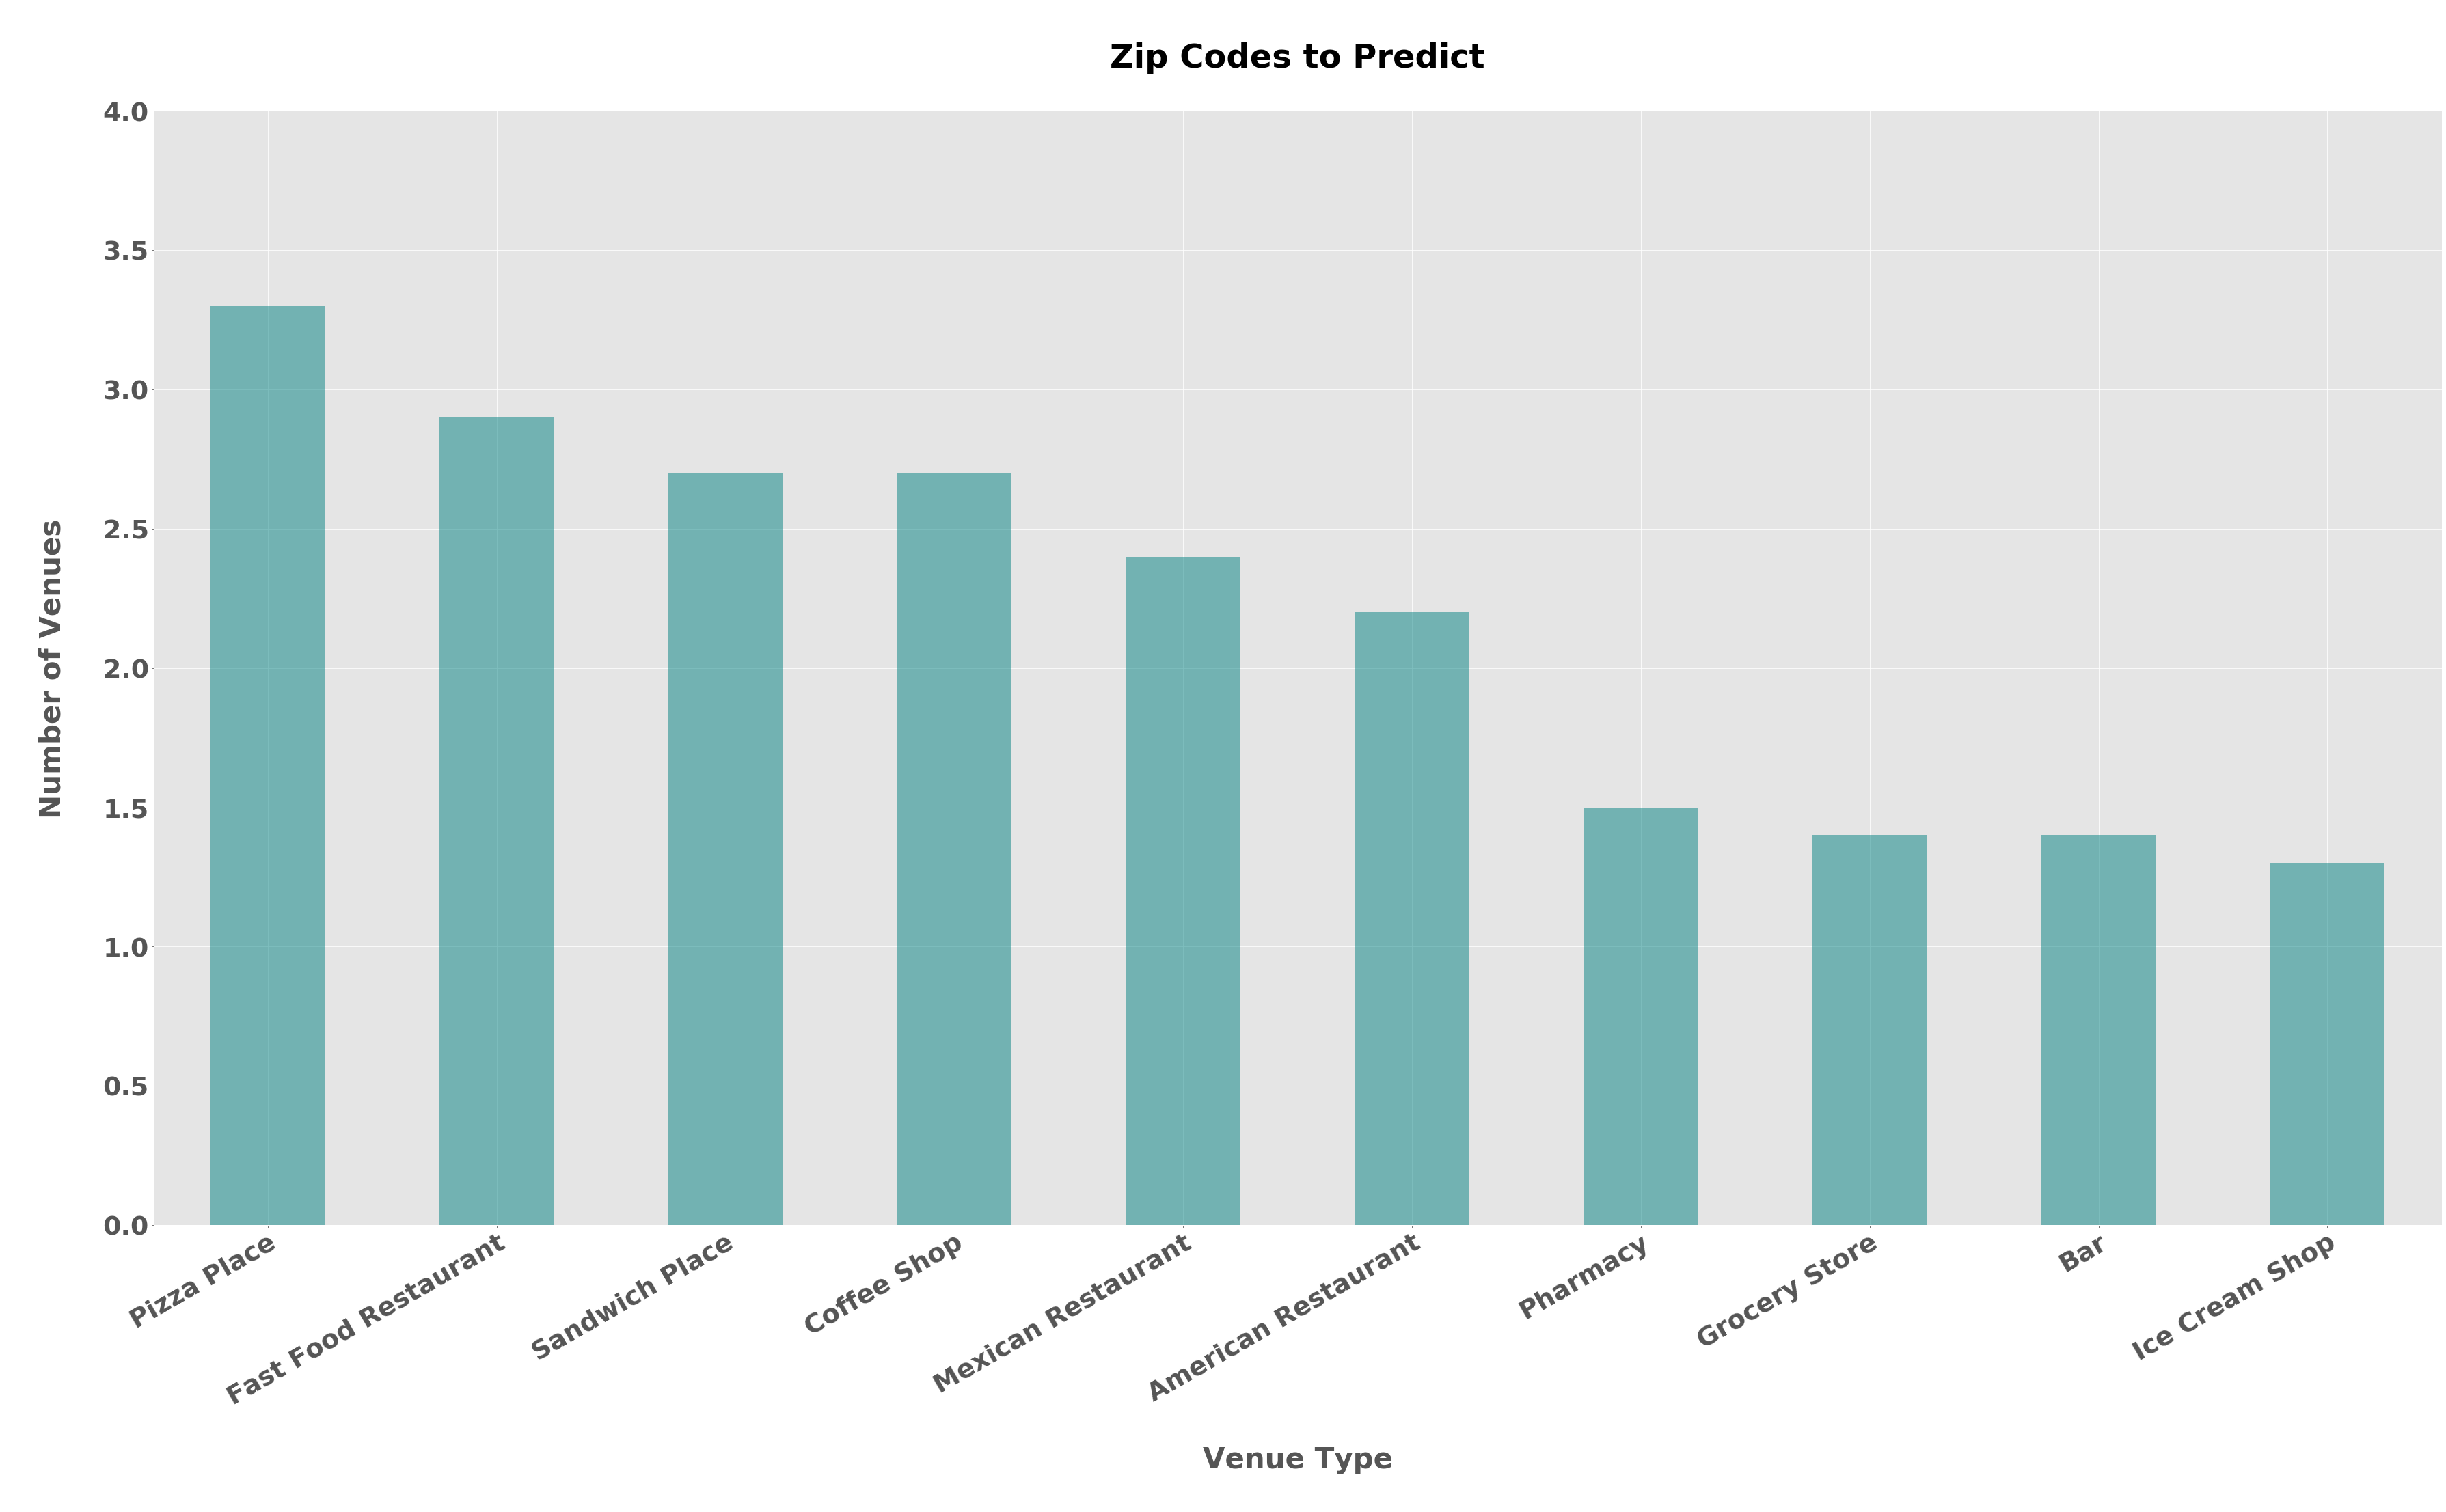

In [49]:
## Bar graph to show most popular venue type in zip codes without CAVA
vis_df.plot(kind = 'bar',
            figsize = (60,30),
            align = 'center',
            color = 'teal',
            alpha = 0.5,
            legend = None)


plt.title('\nZip Codes to Predict\n', fontsize = 48, weight = 'bold') # add title to the plot
plt.xlabel('\nVenue Type\n', fontsize = 42, weight = 'bold') # add to x-label to the plot
plt.xticks(rotation = 30, fontsize = 38, weight = 'bold', rotation_mode = 'anchor', ha = 'right')
plt.ylabel('\nNumber of Venues\n', fontsize = 42, weight = 'bold') # add y-label to the plot
plt.yticks(fontsize = 38, weight = 'bold')
plt.ylim(0,4)


plt.savefig('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/pop_vens_pred_set_bargraph.png', bbox_inches = 'tight')

#### 

# Predict CAVA Success in New Zip Codes with Optimal SVC Model

In [ ]:
#### Load needed libraries

In [85]:
## Standard libraries
import pandas as pd
import numpy as np

## SVC libraries
from sklearn import preprocessing
from sklearn.svm import SVC

## Confirm imports
print('\nLibraries imported\n')


Libraries imported.



In [ ]:
#### Load prediction dataset

In [50]:
## Read in dataframe
prediction_df = pd.read_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/cava_pred_df.csv').drop('Unnamed: 0', axis = 1)

## Show dataframe
print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')   
prediction_df.head()


Dataframe shape: (367, 486)



,Prediction,City,Building,Gym Pool,Hot Dog Joint,Hunting Supply,Arepa Restaurant,Cuban Restaurant,Lighting Store,Medical Lab,Roller Rink,Indoor Play Area,Go Kart Track,Carpet Store,Korean Restaurant,Tapas Restaurant,Video Game Store,Stables,Flea Market,Beach,Disc Golf,Tennis Court,Ramen Restaurant,Big Box Store,Art Museum,Candy Store,Hotel,Juice Bar,Sculpture Garden,Baseball Stadium,Casino,College Library,English Restaurant,Laser Tag,Student Center,Marijuana Dispensary,Resort,Hobby Shop,Bubble Tea Shop,Latin American Restaurant,Museum,Paintball Field,Supplement Shop,Cosmetics Shop,Pet Café,Coffee Shop,Bus Station,Boat or Ferry,Electronics Store,Dumpling Restaurant,Cantonese Restaurant,Print Shop,Military Base,Art Gallery,College Academic Building,Middle School,Other Nightlife,College Basketball Court,Dive Bar,Noodle House,Jewelry Store,Bus Stop,Medical Center,Record Shop,College Auditorium,Neighborhood,Vacation Rental,Speakeasy,Bike Shop,Department Store,Food & Drink Shop,Rest Area,Bistro,Southern / Soul Food Restaurant,Café,Gluten-free Restaurant,Pakistani Restaurant,Chiropractor,Food Truck,Fruit & Vegetable Store,Peruvian Restaurant,Inn,Fabric Shop,Platform,Karaoke Bar,Motel,Afghan Restaurant,Restaurant,Church,Music School,Seafood Restaurant,Shopping Plaza,Indonesian Restaurant,Massage Studio,College Cafeteria,Mobile Phone Shop,Convention Center,Event Space,Rock Climbing Spot,College Administrative Building,Comic Shop,Truck Stop,Recording Studio,Scenic Lookout,Tanning Salon,Sake Bar,College Arts Building,Falafel Restaurant,Gas Station,Gastropub,Comedy Club,Fast Food Restaurant,Skate Park,Distillery,Summer Camp,Soccer Stadium,Deli / Bodega,Men's Store,South Indian Restaurant,Women's Store,Tea Room,American Restaurant,IT Services,Beer Bar,Shabu-Shabu Restaurant,Snack Place,Gourmet Shop,Volleyball Court,Eye Doctor,Doctor's Office,Street Art,Pier,Track Stadium,Convenience Store,Laundromat,Pool Hall,Rock Club,Yoga Studio,Travel & Transport,College Hockey Rink,College Rec Center,Bay,Plaza,Greek Restaurant,Pet Service,Turkish Restaurant,Outdoor Supply Store,Fire Station,Track,Food Court,RV Park,Distribution Center,Breakfast Spot,University,Tour Provider,Garden,Pie Shop,Coworking Space,Frozen Yogurt Shop,Smoothie Shop,Colombian Restaurant,Trade School,State / Provincial Park,Bridal Shop,Chocolate Shop,Field,Food,College Theater,Border Crossing,Cupcake Shop,Photography Studio,Thai Restaurant,Financial or Legal Service,Antique Shop,Spa,Shoe Store,BBQ Joint,Clothing Store,Fish Market,Vineyard,Burger Joint,Fishing Store,Knitting Store,Bed & Breakfast,Non-Profit,Botanical Garden,Pub,Waterfront,Board Shop,Gun Shop,Martial Arts School,Tourist Information Center,Other Great Outdoors,Exhibit,Travel Agency,Library,Skating Rink,Herbs & Spices Store,Trail,Wings Joint,Aquarium,Motorsports Shop,Vegetarian / Vegan Restaurant,Mountain,Public Art,Brazilian Restaurant,Hotel Pool,Theater,Warehouse Store,Stadium,Bridge,Harbor / Marina,Bagel Shop,Campground,Forest,Outdoors & Recreation,Ski Area,Garden Center,Hardware Store,Airport,Scandinavian Restaurant,Factory,Hotpot Restaurant,Bosnian Restaurant,Donut Shop,National Park,Auto Workshop,Empanada Restaurant,Supermarket,Hookah Bar,Airport Lounge,Auto Dealership,Comfort Food Restaurant,Internet Cafe,Dive Spot,Planetarium,Arts & Crafts Store,German Restaurant,College Gym,Buffet,Road,Palace,Shopping Mall,Jazz Club,Zoo Exhibit,Multiplex,Winery,Gym,General Travel,Health & Beauty Service,Office,Asian Restaurant,Shipping Store,Child Care Service,Video Store,Camera Store,Butcher,Hotel Bar,Train Station,Film Studio,Fireworks Store,Sports Club,Recreation Center,Elementary School,Pool,Sporting Goods Shop,Bakery,Cafeteria,Mattress Store,Concert Hall,Music Venue,ATM,Heliport,Outdoor Sculpture,Surf Spot,Other Repair Shop,Thrift / Vintage Store,Stationery Store,Gay Bar,Italian Restaurant,Gaming Cafe,Residential Building (Apartment / Condo),Gymnastics Gym,Brewery,Flower Shop,Modern European Restaurant,Sports Bar,Gym / Fi

In [ ]:
#### Test if prediction dataframe includes every venue type included in optimal SVC model
#### If all present, make prediction_df have only those variables

In [87]:
## Take list of final predictors returned from svc predictor optimization segment of this doc
prediction_df = prediction_df[['Prediction','Zip Code', 'City'] + svc_final_kept_vars.tolist()]

## Show dataframe and its shape
print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')   
prediction_df.head()


Dataframe shape: (367, 10)



,Prediction,Zip Code,City,Garden Center,Shopping Mall,Smoothie Shop,Coffee Shop,Gourmet Shop,Discount Store,Salad Place
0,-,2816,"Coventry, RI",0,1,0,0,0,4,0
1,-,2860,"Pawtucket, RI",0,0,0,1,0,4,0
2,-,2864,"Cumberland, RI",0,0,0,1,0,1,0
3,-,2893,"West Warwick, RI",0,1,0,0,0,2,0
4,-,2904,"Providence, RI",0,0,0,2,0,0,0


In [ ]:
#### Predict if new zip are good CAVA locations

In [90]:
## Use .predict() method of optimal SVC model
prediction_df['Prediction'] = pred_mod.predict(prediction_df.iloc[:, 3:])

## Show prediction results
print('\nDataframe shape: ', prediction_df.shape, '\n', sep = '')
prediction_df.sort_values(by = 'Prediction', ascending = False).head(75)


Dataframe shape: (367, 10)



,Prediction,Zip Code,City,Garden Center,Shopping Mall,Smoothie Shop,Coffee Shop,Gourmet Shop,Discount Store,Salad Place
366,1,99801,"Juneau, AK",0,1,0,4,0,0,0
290,1,84043,"Lehi, UT",0,0,1,4,0,0,0
235,1,68801,"Grand Island, NE",0,0,0,5,0,0,0
237,1,70003,"Metairie, LA",0,0,3,4,0,1,0
140,1,48103,"Ann Arbor, MI",1,0,0,4,0,0,0
98,1,36830,"Auburn, AL",0,0,0,6,0,0,0
281,1,83642,"Meridian, ID",0,0,0,6,0,0,0
282,1,83646,"Meridian, ID",0,0,0,6,0,0,0
284,1,83704,"Boise, ID",0,1,0,6,0,1,2
285,1,83709,"Boise, ID",1,1,0,10,0,1,2


In [ ]:
#### Save finalized prediction dataframe (which now has predictions)

In [116]:
## Save dataframe
prediction_df.sort_values(by = 'Prediction', ascending = False).head(75).to_csv('/Users/mitchelllee/Dropbox/IBM_Data_Science_Certificate/final_cava_pred_df.csv')

## Confirm save
print('\nDataframe saved\n')


Dataframe saved.

